In [1]:
def attention_head(n_tokens, dim, dim_head):
    macs = 0
    
    # token -> k, q, v
    macs += n_tokens * 3 * dim * dim_head
    
    # q * k'
    # (n_tokens, dim_head) * (dim_head, n_tokens) -> (n_tokens, n_tokens)
    macs += n_tokens * dim_head * n_tokens
    
    # Softmax e diviso sqrt(dim_head) 
    # ...
    
    # (q * k') * v
    # (n_tokens, n_tokens) * (n_tokens, dim_head) -> (n_tokens, dim_head)
    macs += n_tokens * n_tokens * dim_head
    
    return macs
    
def attention(n_tokens, dim, dim_head, n_heads):
    macs = 0
    
    macs += n_heads * attention_head(n_tokens, dim, dim_head)
    
    # Riporta gli z concatenati a dimensione dim
    macs += n_tokens * (dim_head * n_heads) * dim if not (n_heads == 1 and dim_head == dim) else 0
    
    return macs

def feed_forward(n_tokens, dim, mlp_dim):
    # 2 Linear: dim -> mlp_dim, mlp_dim -> dim
    return n_tokens * dim * mlp_dim * 2

def transformer(n_tokens, dim, dim_head, n_heads, mlp_dim, depth):
    return depth * (attention(n_tokens, dim, dim_head, n_heads) + feed_forward(n_tokens, dim, mlp_dim))

def vit(patch_size, dim, dim_head, n_heads, mlp_dim, depth):
    macs = 0
    
    n_tokens = 300 // patch_size
    
    # linear embedding
    macs += n_tokens * (14 * patch_size) * dim
    
    # +1 perché c'è cls_token
    macs += transformer(n_tokens + 1, dim, dim_head, n_heads, mlp_dim, depth)
    
    # output
    # Da mean o last token a class_scores
    macs += dim * 8
    
    return macs

import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)
               
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        qkv = qkv.chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0., use_cls_token=True):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        #self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.use_cls_token = use_cls_token
        if self.use_cls_token:
            self.pos_embedding = nn.Parameter(torch.empty(1, num_patches + 1, dim))
        else:
            self.pos_embedding = nn.Parameter(torch.empty(1, num_patches, dim))
        #nn.init.kaiming_uniform_(self.pos_embedding, a=5 ** .5)
        nn.init.normal_(self.pos_embedding, std=.02)

        #self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.cls_token = nn.Parameter(torch.empty(1, 1, dim))
        nn.init.zeros_(self.cls_token)
        
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        # MACs: patch_size * n_patches * dim, es (30 * 14) * 10 * 300
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape
        
        if self.use_cls_token:
            cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
            x = torch.cat((cls_tokens, x), dim=1)
            x += self.pos_embedding[:, :(n + 1)]
        else :
            x += self.pos_embedding
        
        x = self.dropout(x)
        
        # FeedForward    Attention       project out
        # 300*300*10*2 + 300*(64*3)*10 + ((64)*300*10)
        # Attention -> manca softmax e attention vera e propria, c'è solo linear encoding a qkv
        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        
        x = self.to_latent(x)
        x = self.mlp_head(x)
        return x

In [2]:
vit(patch_size=10, dim=64, dim_head=32, n_heads=8, mlp_dim=128, depth=1) / 1e6

3.300864

In [3]:
vit(patch_size=5, dim=64, dim_head=32, n_heads=2, mlp_dim=128, depth=4) / 1e6

10.169856

In [4]:
# Ratio of params
def vit_aff_ratio(patch_size, dim, dim_head, n_heads, mlp_dim, depth): 
    n_tokens = 300 // patch_size + 1
    
    a = (((dim) * dim_head * 3 * n_heads) + ((dim_head * n_heads) * dim) + dim)
    ff = dim * mlp_dim * 2 + mlp_dim + dim
    
    return a / (a + ff)

In [5]:
def get_results(configs, results_, additional_columns, extract_model_hparams):
        
    acccs = []
    acccs_steady = []
    acccs_val0 = []
    acccs_steady_val0 = []
    acccs_val1 = []
    acccs_steady_val1 = []

    acccs_val_val0 = 0
    acccs_val_val1 = 0
    acccs_train_val0 = 0
    acccs_train_val1 = 0
    
    acccs_steady_persubject = np.array([0] * 10, dtype=float)
    preds_steady_bincounts_subject = np.zeros((10, 8), dtype=int)
    
    for config, r in zip(configs, results_):

        accs = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_0']['y_preds'], r['val-fold_0']['y_trues'])):
            accs[i] += (y_pred == y_true).sum().float() / len(y_true)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_1']['y_preds'], r['val-fold_1']['y_trues'])):
            accs[i] += (y_pred == y_true).sum().float() / len(y_true)
        accs /= 2

        accs_steady = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_0']['y_preds_steady'], r['val-fold_0']['y_trues_steady'])):
            accs_steady[i] += (y_pred == y_true).sum().float() / len(y_true)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_1']['y_preds_steady'], r['val-fold_1']['y_trues_steady'])):
            accs_steady[i] += (y_pred == y_true).sum().float() / len(y_true)
        accs_steady /= 2

        accs_val0 = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_0']['y_preds'], r['val-fold_0']['y_trues'])):
            accs_val0[i] += (y_pred == y_true).sum().float() / len(y_true)

        accs_steady_val0 = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_0']['y_preds_steady'], r['val-fold_0']['y_trues_steady'])):
            accs_steady_val0[i] += (y_pred == y_true).sum().float() / len(y_true)
            acccs_steady_persubject[r['subject'] - 1] += (y_pred == y_true).sum().float() / len(y_true)
            preds_steady_bincounts_subject[r['subject'] - 1] += y_pred.bincount(minlength=(y_true.max() + 1)).numpy()
            
        accs_val1 = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_1']['y_preds'], r['val-fold_1']['y_trues'])):
            accs_val1[i] += (y_pred == y_true).sum().float() / len(y_true)

        accs_steady_val1 = np.array([0] * len(r['test_sessions']), dtype=float)
        for i, (y_pred, y_true) in enumerate(zip(r['val-fold_1']['y_preds_steady'], r['val-fold_1']['y_trues_steady'])):
            accs_steady_val1[i] += (y_pred == y_true).sum().float() / len(y_true)
            acccs_steady_persubject[r['subject'] - 1] += (y_pred == y_true).sum().float() / len(y_true)
            preds_steady_bincounts_subject[r['subject'] - 1] += y_pred.bincount(minlength=(y_true.max() + 1)).numpy()
            
        acccs_train_val0 += r['val-fold_0']['losses_accs'][-1]['train_acc']
        acccs_train_val1 += r['val-fold_1']['losses_accs'][-1]['train_acc']

        acccs_val_val0 += r['val-fold_0']['losses_accs'][-1]['val_acc']
        acccs_val_val1 += r['val-fold_1']['losses_accs'][-1]['val_acc']

        acccs.append(accs)
        acccs_steady.append(accs_steady)
        acccs_val0.append(accs_val0)
        acccs_steady_val0.append(accs_steady_val0)
        acccs_val1.append(accs_val1)
        acccs_steady_val1.append(accs_steady_val1)
        
    test_sessions = len(r['test_sessions'])

    acccs_steady_persubject /= test_sessions * 2 # 5 sessioni per due

    acccs = np.array(acccs).mean(axis=0)

    acccs_steady_ = np.array(acccs_steady).mean(axis=1)
    acccs_steady = np.array(acccs_steady).mean(axis=0)

    acccs_val0 = np.array(acccs_val0).mean(axis=0)
    acccs_val1 = np.array(acccs_val1).mean(axis=0)
    acccs_steady_val0 = np.array(acccs_steady_val0).mean(axis=0)
    acccs_steady_val1 = np.array(acccs_steady_val1).mean(axis=0)
    acccs_val_val0 /= 10
    acccs_val_val1 /= 10
    acccs_train_val0 /= 10
    acccs_train_val1 /= 10
    
    model_hparams = extract_model_hparams(config)

    return {        
        **model_hparams,

        **additional_columns,

        "train accuracy steady fold1":  acccs_train_val0,
        "train accuracy steady fold2":  acccs_train_val1,
        "train accuracy steady avg2folds": .5 * (acccs_train_val0 + acccs_train_val1),

        "validation accuracy steady fold1": acccs_val_val0,
        "validation accuracy steady fold2": acccs_val_val1,

        "test accuracy fold1": acccs_val0.mean(),
        "test accuracy fold2": acccs_val1.mean(),
        "test accuracy avg2folds": acccs.mean(), 
        "test accuracy steady fold1": acccs_steady_val0.mean(),
        "test accuracy steady fold2": acccs_steady_val1.mean(), 
        "test accuracy steady avg2folds": acccs_steady.mean(),

        "test accuracy steady avg2folds std across sessions": acccs_steady.std(),
        "test accuracy steady avg2folds std across subjects": acccs_steady_.std(),
        
        **{
          f"test accuracy steady session{s + 1 + test_sessions} avg2folds": acccs_steady[s] for s in range(test_sessions)
        },
        
        **{
            f"test accuracy steady subj{s} avg2folds": acccs_steady_persubject[s] for s in range(10)
        },
        
        **{
            f"test preds steady subj{s} avg2folds": preds_steady_bincounts_subject[s] for s in range(10)
        },
    }

In [6]:
from pickle import load

import numpy as np
import pandas as pd

def group_configs(configs, group_exclude_columns):
    # https://stackoverflow.com/a/6027615
    import collections.abc

    def flatten(d, parent_key='', sep='_'):
        items = []
        for k, v in d.items():
            new_key = parent_key + sep + k if parent_key else k
            if isinstance(v, collections.abc.MutableMapping):
                items.extend(flatten(v, new_key, sep=sep).items())
            else:
                items.append((new_key, v))
        return dict(items)

    df = pd.DataFrame([flatten(config) for config in configs])
    df['row_id'] = [[a] for a in df.index]
    
    if 'training_config_lr_scheduler_hparams_milestones' in df:
        df['training_config_lr_scheduler_hparams_milestones'] = df['training_config_lr_scheduler_hparams_milestones'].apply(lambda x: ','.join(map(str, x)))
    df = df.fillna('null')
    
    grouped_configs = df.groupby([c for c in df.columns if c not in group_exclude_columns]).agg({'subjects': 'count', 'row_id': 'sum'})
    
    if (grouped_configs['subjects'] != 10).sum() != 0:
        display(grouped_configs)
        raise ValueError("For every config, it is assumed that you trained on 10 subjects")
    
    return list(grouped_configs["row_id"])


extract_model_hparams_generator = {
    'vit': lambda config: {
        "window_size": config["image_size"][1],
        "patch_size": config["patch_size"][1],
        "dim_projection": config["dim"],
        "dim_ff": config["mlp_dim"],
        "dim_head": config["dim_head"],
        "n_heads": config["heads"],
        "depth": config["depth"],
        "dropout": config["dropout"],
        "emb_dropout": config["emb_dropout"],
        
        "MACs": vit(patch_size=config["patch_size"][1], dim=config["dim"], dim_head=config["dim_head"], n_heads=config["heads"], mlp_dim=config["mlp_dim"], depth=config["depth"]),
        "params":  sum([param.nelement() for param in ViT(image_size=(1, 300), patch_size=config["patch_size"], dim=config["dim"], dim_head=config["dim_head"], heads=config["heads"], mlp_dim=config["mlp_dim"], depth=config["depth"], num_classes=8).parameters()]),
        "params_aff_ratio": vit_aff_ratio(patch_size=config["patch_size"][1], dim=config["dim"], dim_head=config["dim_head"], n_heads=config["heads"], mlp_dim=config["mlp_dim"], depth=config["depth"]),
        
    },
    'temponet': lambda _: {
        "MACs": 16028672,
        "params": 461512,
    },
}

def read_results(filename, additional_columns=None, group_exclude_columns=None, model_name='vit'):
    additional_columns = {} if additional_columns is None else additional_columns
    
    group_exclude_columns = set() if group_exclude_columns is None else group_exclude_columns
    group_exclude_columns = group_exclude_columns.union({'subjects', 'row_id'})
    
    configs, results_ = load(open(filename, 'rb'))
    
    groups_indices = group_configs(configs, group_exclude_columns)
    
    df_l = []
    for idx in groups_indices:
        c = [configs[i] for i in idx]
        r = [results_[i] for i in idx]
        
        df_l.append(get_results(c, r, additional_columns, extract_model_hparams_generator[model_name]))   
    
    return pd.DataFrame(df_l) 

In [7]:
import matplotlib.pyplot as plt

def plot_r(res, ax, legend=True):
    for h in [2, 4, 8]:
        r = res[res["n_heads"] == h]
        ax.grid('on')
        ax.plot(list(map(str, r["depth"])), r["test accuracy steady avg2folds"], marker='.', markersize=10, label=h)
        ax.set_xlabel("depth")

    if legend:
        ax.legend(title="n_heads", loc="upper right", bbox_to_anchor=(1.25, 1.02))

In [8]:
def get_rows(all_res_vit, group):
    m = None
    for k in group.keys():
        current_m = all_res_vit[k] == group[k]
        if m is None:
            m = current_m
        else:
            m &= current_m
    return all_res_vit[m].copy()

In [9]:
all_res_tcn = read_results("exp7/tcn_pretrain/results_1625075271.pickle", {"pretraining": 'fold1'}, model_name='temponet') \
.append(read_results("exp7/tcn_pretrain/results_1625166399.pickle", {"pretraining": 'no'}, model_name='temponet'), ignore_index=True) \
.append(read_results("exp7/tcn_pretrain/results_1626361771.pickle", {"pretraining": 'fold2'}, model_name='temponet'), ignore_index=True)

In [10]:
all_res_tcn

,MACs,params,pretraining,train accuracy steady fold1,train accuracy steady fold2,train accuracy steady avg2folds,validation accuracy steady fold1,validation accuracy steady fold2,test accuracy fold1,test accuracy fold2,...,test preds steady subj0 avg2folds,test preds steady subj1 avg2folds,test preds steady subj2 avg2folds,test preds steady subj3 avg2folds,test preds steady subj4 avg2folds,test preds steady subj5 avg2folds,test preds steady subj6 avg2folds,test preds steady subj7 avg2folds,test preds steady subj8 avg2folds,test preds steady subj9 avg2folds
0,16028672,461512,fold1,0.972680,0.936642,0.954661,0.729058,0.782328,0.514245,0.498983,...,"[41761, 9419, 7582, 8340, 4600, 12463, 7532, 5...","[37119, 4278, 669, 2142, 10619, 10303, 13695, ...","[54680, 4673, 4749, 3715, 7377, 10138, 7444, 4...","[45744, 4670, 3706, 4408, 7799, 14860, 8604, 7...","[51992, 6378, 6818, 9223, 4937, 6060, 5890, 6032]","[41153, 6233, 6108, 7453, 4625, 15256, 9187, 6...","[39608, 7525, 11169, 9726, 6539, 6973, 11153, ...","[60333, 6472, 5313, 4297, 6920, 2001, 5794, 6812]","[70701, 8569, 5395, 3763, 2805, 2938, 3135, 1762]","[41551, 4838, 3303, 7261, 17930, 12066, 5486, ..."
1,16028672,461512,no,0.974000,0.959895,0.966948,0.717230,0.712031,0.505880,0.485882,...,"[41195, 8864, 7610, 9814, 5003, 10813, 8871, 5...","[36503, 6526, 4311, 6985, 15105, 12232, 8314, ...","[44115, 4921, 8910, 5348, 7388, 8318, 7826, 10...","[44170, 6069, 6942, 6512, 6156, 13583, 5692, 7...","[52770, 9859, 6769, 8226, 4626, 4379, 6328, 4373]","[43433, 4732, 6462, 4381, 7791, 11937, 9756, 8...","[43133, 7445, 8641, 5002, 8652, 7306, 13490, 3...","[51466, 11892, 8295, 6710, 5720, 3168, 5487, 5...","[63889, 11368, 5203, 6033, 3061, 3203, 4351, 1...","[43127, 4795, 5573, 7677, 12970, 14527, 4192, ..."
2,16028672,461512,fold2,0.948968,0.969305,0.959136,0.779266,0.732315,0.520106,0.501060,...,"[41624, 9780, 5801, 8449, 7275, 12831, 6554, 4...","[37817, 4891, 587, 2131, 13207, 13443, 9379, 1...","[51831, 4557, 5239, 5185, 7867, 9730, 8153, 4840]","[44628, 5419, 3706, 5264, 8743, 12586, 8489, 8...","[52592, 6600, 7631, 8541, 4727, 5305, 6335, 5599]","[43232, 6764, 5568, 7903, 5554, 13369, 9646, 4...","[37701, 8040, 9797, 8606, 8705, 8349, 11502, 4...","[53209, 8349, 5806, 5042, 8848, 2572, 9339, 4777]","[70069, 7807, 3504, 3382, 5400, 3586, 3676, 1644]","[45676, 3219, 3911, 8102, 17511, 10488, 3914, ..."


In [11]:
all_res_vit = \
    read_results("exp5/grid_5sess10subj/finetuneFrom20/results_1623756488.pickle", {"pretraining": "fold1", "pretraining_dropout": .2, "pretraining_epochs": 20, "finetune_epochs": 20}) \
    .append(read_results("exp5/grid_5sess10subj/finetuneFrom20For40epochs/results_1623776968.pickle", {"pretraining_epochs": 20, "finetune_epochs": 40}), ignore_index=True) \
    .append(read_results("exp5/grid_5sess10subj/finetuneFrom100/results_1623845783.pickle", {"pretraining_epochs": 100, "finetune_epochs": 20}), ignore_index=True) \
    .append(read_results("exp6/grid_5sess10subj_dim64_p10/finetune_100/results_1624706075.pickle", {"pretraining_epochs": 100, "finetune_epochs": 20}), ignore_index=True) \
    .append(read_results("exp6/grid_5sess10subj_dim64_p30/finetune_100/results_1624804897.pickle", {"pretraining_epochs": 100, "finetune_epochs": 20}), ignore_index=True) \
    .append(read_results("exp8/grid_5sess10subj_patches/finetune_100/results_1626031724.pickle", {"pretraining_epochs": 100, "finetune_epochs": 20}), ignore_index=True) \
    .append(read_results("exp9/grid_5sess10subj_patches/finetune_100/results_1626498530.pickle", {"pretraining_epochs": 100, "finetune_epochs": 20}), ignore_index=True) \
    .append(read_results("exp6/grid_5sess10subj_dim128/finetune_100/results_1624542865.pickle", {"pretraining_epochs": 100, "finetune_epochs": 20}), ignore_index=True) \
    .append(read_results("exp6/grid_5sess10subj_dim64_biggerff/finetune_100/results_1624804989.pickle", {"pretraining_epochs": 100, "finetune_epochs": 20}), ignore_index=True) \
    .append(read_results("exp6/grid_5sess10subj_dim128_hd/finetune_100/results_1624537254.pickle", {"pretraining_dropout": .4, "pretraining_epochs": 100, "finetune_epochs": 20}), ignore_index=True) \
    .append(read_results("exp6/grid_5sess10subj_dim128_hd/finetune_200/results_1624561227.pickle", {"pretraining_dropout": .4, "pretraining_epochs": 200, "finetune_epochs": 20}), ignore_index=True) \
    .append(read_results("exp6/grid_5sess10subj_dim128_hd/finetune_300/results_1624568054.pickle", {"pretraining_dropout": .4, "pretraining_epochs": 300, "finetune_epochs": 20}), ignore_index=True) \
    .append(read_results("exp7/grid_5sess10subj_dim64_biggerff_hd/finetune_100/results_1625404399.pickle", {"pretraining_dropout": .5, "pretraining_epochs": 100, "finetune_epochs": 20}), ignore_index=True) \
    .append(read_results("exp6/grid_5sess10subj_dim64_biggerff_h64/finetune_100/results_1625066718.pickle", {"pretraining_epochs": 100, "finetune_epochs": 20}), ignore_index=True) \
    .append(read_results("exp7/grid_5sess10subj_dim64_biggerff_h16/finetune_100/results_1625348485.pickle", {"pretraining_epochs": 100, "finetune_epochs": 20}), ignore_index=True) \
    .append(read_results("exp8/grid_5sess10subj_pretraining/finetune_100/results_1626016643.pickle", {"pretraining": 'all_others', "pretraining_epochs": 100, "finetune_epochs": 20}, group_exclude_columns={'pretrained'}), ignore_index=True) \
    .append(read_results("exp8/grid_5sess10subj_nopretraining/finetune_0/results_1626180786.pickle", {"pretraining": 'no', "pretraining_epochs": 0, "finetune_epochs": 200}, group_exclude_columns={'pretrained'}), ignore_index=True) \
    .append(read_results("exp8/grid_5sess10subj_pretraining_fold1/finetune_100/results_1626221775.pickle", {"pretraining": 'fold2', "pretraining_epochs": 100, "finetune_epochs": 20}), ignore_index=True) \
    .append(read_results("exp9/grid_5sess10subj_pretraining/finetune_100/results_1626421922.pickle", {"pretraining": 'all_others', "pretraining_epochs": 100, "finetune_epochs": 20}, group_exclude_columns={'pretrained'}), ignore_index=True) \
    .append(read_results("exp9/grid_5sess10subj_nopretraining/finetune_0/results_1626391555.pickle", {"pretraining": 'no', "pretraining_epochs": 0, "finetune_epochs": 200}, group_exclude_columns={'pretrained'}), ignore_index=True) \
    .append(read_results("exp9/grid_5sess10subj_pretraining_fold1/finetune_100/results_1626387182.pickle", {"pretraining": 'fold2', "pretraining_epochs": 100, "finetune_epochs": 20}), ignore_index=True) \
    .fillna(value={"pretraining": "fold1", "pretraining_dropout": .2, })

In [12]:
all_res_vit_2 = \
    read_results("exp10/no_pretraining_/results_1630304612.pickle", {"pretraining": False}) \
    .append(read_results("exp10/no_pretraining_/results_1630304773.pickle", {"pretraining": False}), ignore_index=True) \

In [13]:
all_res_vit_2

,window_size,patch_size,dim_projection,dim_ff,dim_head,n_heads,depth,dropout,emb_dropout,MACs,...,test preds steady subj0 avg2folds,test preds steady subj1 avg2folds,test preds steady subj2 avg2folds,test preds steady subj3 avg2folds,test preds steady subj4 avg2folds,test preds steady subj5 avg2folds,test preds steady subj6 avg2folds,test preds steady subj7 avg2folds,test preds steady subj8 avg2folds,test preds steady subj9 avg2folds
0,300,1,64,128,32,2,2,0.2,0,43189504,...,"[43187, 8156, 7896, 9491, 4667, 8065, 9974, 5816]","[37847, 7611, 4839, 7223, 14064, 11423, 8600, ...","[54167, 6247, 7880, 4770, 7211, 6753, 6055, 4319]","[45684, 7798, 6602, 6259, 4843, 12113, 6720, 6...","[51815, 9445, 8025, 7085, 3310, 6760, 7258, 3632]","[46160, 4022, 5296, 6236, 6379, 10579, 13235, ...","[38237, 7678, 7921, 4146, 8261, 9553, 16172, 5...","[57019, 13423, 7309, 5183, 2940, 866, 5846, 5356]","[62223, 6950, 3754, 2421, 5693, 5676, 5975, 6376]","[42456, 6551, 8515, 11233, 9357, 10673, 4963, ..."
1,300,5,64,128,32,2,2,0.2,0,5219584,...,"[41514, 9530, 6596, 10238, 5133, 9680, 8427, 6...","[35365, 8727, 7179, 6387, 11743, 9794, 10785, ...","[97402, 0, 0, 0, 0, 0, 0, 0]","[44985, 9807, 5983, 7264, 5945, 9981, 8235, 4814]","[52398, 10470, 8277, 6772, 3168, 6063, 6219, 3...","[45767, 6006, 4230, 5534, 6910, 11975, 11352, ...","[37534, 9143, 9353, 4300, 12649, 8597, 11091, ...","[58478, 14365, 4818, 5516, 3539, 2255, 4755, 4...","[64952, 5502, 4970, 2679, 5363, 4627, 5070, 5905]","[43711, 3260, 9903, 11157, 8257, 10275, 4766, ..."
2,300,10,64,128,32,2,2,0.2,0,2546944,...,"[41462, 9444, 7334, 8530, 5326, 9941, 9181, 6034]","[36108, 9457, 6236, 7689, 11688, 11442, 6994, ...","[97402, 0, 0, 0, 0, 0, 0, 0]","[45312, 9164, 4705, 7399, 6524, 11294, 7089, 5...","[52370, 8971, 7802, 6887, 4246, 6178, 7005, 3871]","[43769, 6798, 5192, 6624, 5234, 12067, 11689, ...","[35682, 8339, 9518, 4546, 11689, 9738, 12897, ...","[57818, 14246, 5133, 5963, 4123, 1111, 4624, 4...","[69998, 6006, 4421, 2256, 5180, 4146, 4742, 2319]","[40489, 5462, 10051, 10663, 7619, 11201, 5504,..."
3,300,20,64,128,32,2,2,0.2,0,1383424,...,"[42158, 9540, 7301, 8614, 4800, 9958, 9611, 5270]","[35622, 9300, 5871, 9131, 11873, 11937, 6171, ...","[97402, 0, 0, 0, 0, 0, 0, 0]","[44034, 7208, 6065, 6992, 6824, 11588, 8374, 5...","[52086, 7590, 7681, 7195, 4954, 6602, 6627, 4595]","[42810, 6183, 4241, 6549, 6437, 10861, 14041, ...","[34663, 8177, 10770, 6033, 10989, 8197, 12732,...","[52713, 14366, 4671, 8078, 4904, 1252, 7186, 4...","[71077, 6120, 6281, 3176, 3280, 3140, 3461, 2533]","[39312, 5532, 9329, 7842, 10003, 11640, 6131, ..."
4,300,30,64,128,32,2,2,0.2,0,1021184,...,"[42923, 9622, 7395, 9538, 4378, 8408, 9263, 5725]","[34790, 11215, 6622, 9680, 8132, 12031, 6804, ...","[97402, 0, 0, 0, 0, 0, 0, 0]","[45716, 7364, 6149, 6133, 7353, 12533, 5652, 6...","[51780, 7779, 7168, 7797, 4670, 6714, 7470, 3952]","[41119, 5289, 7622, 4262, 6235, 12594, 12124, ...","[97376, 0, 0, 4, 0, 0, 0, 0]","[50981, 14330, 6682, 7251, 4597, 1565, 5985, 6...","[70339, 6574, 5431, 4750, 4083, 3114, 3053, 1724]","[39510, 5785, 10044, 9069, 8371, 11587, 5226, ..."
5,300,1,64,128,32,8,1,0.2,0,71314944,...,"[43623, 7985, 6930, 9301, 5161, 8475, 9596, 6181]","[36690, 6943, 7554, 8622, 10251, 13566, 7383, ...","[57632, 4787, 5930, 5885, 7374, 7356, 5806, 2632]","[48957, 7539, 4213, 6970, 5851, 10655, 6606, 6...","[52615, 9619, 6726, 6708, 2883, 6705, 8355, 3719]","[49027, 5022, 5577, 5356, 6522, 12257, 10181, ...","[39280, 6921, 8431, 3582, 11105, 7018, 14210, ...","[62704, 10288, 6732, 4327, 3253, 1404, 4167, 5...","[66829, 11211, 3221, 3415, 4268, 3634, 4247, 2...","[45716, 4416, 8447, 8428, 10921, 10293, 4035, ..."
6,300,5,64,128,32,8,1,0.2,0,7171584,...,"[41244, 9413, 8238, 8920, 4555, 10378, 9306, 5...","[36581, 8157, 4991, 9038, 14573, 11720, 6317, ...","[53427, 6255, 9181, 4568, 6746, 9324, 4980, 2921]","[46214, 7386, 4599, 7574, 6777, 11739, 6804, 5...","[52171, 7312, 9313, 8310, 4397, 6062, 5583, 4182]","[

In [14]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [15]:
all_res_vit

,window_size,patch_size,dim_projection,dim_ff,dim_head,n_heads,depth,dropout,emb_dropout,MACs,params,params_aff_ratio,pretraining,pretraining_dropout,pretraining_epochs,finetune_epochs,train accuracy steady fold1,train accuracy steady fold2,train accuracy steady avg2folds,validation accuracy steady fold1,validation accuracy steady fold2,test accuracy fold1,test accuracy fold2,test accuracy avg2folds,test accuracy steady fold1,test accuracy steady fold2,test accuracy steady avg2folds,test accuracy steady avg2folds std across sessions,test accuracy steady avg2folds std across subjects,test accuracy steady session6 avg2folds,test accuracy steady session7 avg2folds,test accuracy steady session8 avg2folds,test accuracy steady session9 avg2folds,test accuracy steady session10 avg2folds,test accuracy steady subj0 avg2folds,test accuracy steady subj1 avg2folds,test accuracy steady subj2 avg2folds,test accuracy steady subj3 avg2folds,test accuracy steady subj4 avg2folds,test accuracy steady subj5 avg2folds,test accuracy steady subj6 avg2folds,test accuracy steady subj7 avg2folds,test accuracy steady subj8 avg2folds,test accuracy steady subj9 avg2folds,test preds steady subj0 avg2folds,test preds steady subj1 avg2folds,test preds steady subj2 avg2folds,test preds steady subj3 avg2folds,test preds steady subj4 avg2folds,test preds steady subj5 avg2folds,test preds steady subj6 avg2folds,test preds steady subj7 avg2folds,test preds steady subj8 avg2folds,test preds steady subj9 avg2folds
0,300,20,64,128,32,2,1,0.2,0,826368,38920,0.498062,fold1,0.2,20,20,0.712717,0.669166,0.690942,0.593935,0.597517,0.440826,0.426274,0.433550,0.578663,0.560021,0.569342,0.021177,0.069512,0.587474,0.571392,0.596881,0.547953,0.543009,0.640837,0.541336,0.583173,0.582914,0.714141,0.606549,0.516840,0.542599,0.458561,0.506469,"[43667, 11324, 5034, 11275, 5055, 8581, 7129, ...","[33804, 6499, 5490, 3495, 8387, 10464, 12368, ...","[51522, 4596, 10242, 6107, 4798, 9032, 5937, 5...","[44922, 13119, 3575, 4013, 2488, 10940, 8207, ...","[50879, 6852, 7328, 7870, 5893, 6685, 6042, 5781]","[42321, 5722, 4929, 4303, 6916, 13344, 11011, ...","[36670, 8311, 13202, 8813, 10311, 4932, 9748, ...","[51297, 13560, 5851, 6070, 2959, 1794, 6883, 9...","[57609, 18565, 6527, 5458, 2358, 1989, 3455, 3...","[40344, 8804, 7691, 5197, 9446, 9562, 6242, 9954]"
1,300,20,64,128,32,4,1,0.2,0,1121280,55304,0.664508,fold1,0.2,20,20,0.778950,0.731730,0.755340,0.628403,0.631077,0.460616,0.445341,0.452979,0.606442,0.587226,0.596834,0.020483,0.064312,0.619140,0.599758,0.618445,0.569702,0.577124,0.681274,0.559302,0.603005,0.608345,0.740284,0.590301,0.564457,0.567866,0.514103,0.539402,"[42642, 11331, 7241, 10350, 4233, 8917, 7262, ...","[35636, 5304, 1921, 2099, 7704, 10272, 13453, ...","[50679, 4253, 7522, 5906, 7788, 9388, 6453, 5413]","[44247, 10897, 4250, 4315, 3842, 12880, 8489, ...","[51307, 8089, 7884, 6521, 6397, 6227, 5960, 4945]","[42089, 4768, 5811, 4650, 6994, 14309, 12376, ...","[37873, 8328, 14535, 8422, 8669, 4838, 10519, ...","[56118, 10191, 5195, 6534, 4610, 1955, 6747, 6...","[66347, 12185, 4603, 4146, 3358, 2788, 3491, 2...","[42483, 6345, 8371, 6086, 9700, 10539, 4944, 8..."
2,300,20,64,128,32,8,1,0.2,0,1711104,88072,0.798287,fold1,0.2,20,20,0.828841,0.784686,0.806763,0.655905,0.657439,0.476512,0.458469,0.467491,0.629155,0.604081,0.616618,0.021080,0.066983,0.641625,0.616504,0.638703,0.591516,0.594743,0.706545,0.565795,0.607541,0.631915,0.769407,0.600127,0.600527,0.574534,0.537363,0.572426,"[42685, 11164, 6068, 9652, 5145, 10253, 6949, ...","[35173, 4914, 2976, 2137, 6601, 10459, 13407, ...","[49935, 4379, 6267, 5199, 9254, 9498, 7229, 5641]","[44287, 9394, 5171, 4414, 4132, 13010, 8579, 8...","[51644, 8114, 7985, 6463, 5884, 6417, 5789, 5034]","[41173, 4768, 6124, 5639, 5495, 15794, 11949, ...","[37592, 8126, 11379, 10096, 7513, 6657, 11570,...","[56727, 8763, 4839, 6271, 5658, 1410, 7227, 7047]","[71321, 6595, 4523, 3316, 3933, 3661, 3513, 2206]","[40575, 7135, 8122, 8534, 9226,

In [16]:
all_res_da_vit = read_results("exp9/wide_v2/finetune_25_da/results_1627152123.pickle", {"pretraining": "fold1", "pretraining_dropout": .2, "pretraining_epochs": 25, "finetune_epochs": 10}) \
.append(read_results("exp9/wide_v2/finetune_50_da/results_1627172938.pickle", {"pretraining": "fold1", "pretraining_dropout": .2, "pretraining_epochs": 50, "finetune_epochs": 10}), ignore_index=True) \
.append(read_results("exp9/wide_v2_hactar/finetune_5_da/results_1627337456.pickle", {"pretraining": "fold1", "pretraining_dropout": .2, "pretraining_epochs": 5, "finetune_epochs": 10}), ignore_index=True) \
.append(read_results("exp9/wide_v2_hactar/finetune_25_da/results_1627340701.pickle", {"pretraining": "fold1", "pretraining_dropout": .2, "pretraining_epochs": 25, "finetune_epochs": 10}), ignore_index=True) \
.append(read_results("exp9/wide_v2_d4/finetune_25_da/results_1627297764.pickle", {"pretraining": "fold1", "pretraining_dropout": .2, "pretraining_epochs": 25, "finetune_epochs": 10}), ignore_index=True) \
.append(read_results("exp9/wide_v2_d4/finetune_50_da/results_1627315477.pickle", {"pretraining": "fold1", "pretraining_dropout": .2, "pretraining_epochs": 50, "finetune_epochs": 10}), ignore_index=True) \

In [17]:
all_res_da_vit

,window_size,patch_size,dim_projection,dim_ff,dim_head,n_heads,depth,dropout,emb_dropout,MACs,params,params_aff_ratio,pretraining,pretraining_dropout,pretraining_epochs,finetune_epochs,train accuracy steady fold1,train accuracy steady fold2,train accuracy steady avg2folds,validation accuracy steady fold1,validation accuracy steady fold2,test accuracy fold1,test accuracy fold2,test accuracy avg2folds,test accuracy steady fold1,test accuracy steady fold2,test accuracy steady avg2folds,test accuracy steady avg2folds std across sessions,test accuracy steady avg2folds std across subjects,test accuracy steady session6 avg2folds,test accuracy steady session7 avg2folds,test accuracy steady session8 avg2folds,test accuracy steady session9 avg2folds,test accuracy steady session10 avg2folds,test accuracy steady subj0 avg2folds,test accuracy steady subj1 avg2folds,test accuracy steady subj2 avg2folds,test accuracy steady subj3 avg2folds,test accuracy steady subj4 avg2folds,test accuracy steady subj5 avg2folds,test accuracy steady subj6 avg2folds,test accuracy steady subj7 avg2folds,test accuracy steady subj8 avg2folds,test accuracy steady subj9 avg2folds,test preds steady subj0 avg2folds,test preds steady subj1 avg2folds,test preds steady subj2 avg2folds,test preds steady subj3 avg2folds,test preds steady subj4 avg2folds,test preds steady subj5 avg2folds,test preds steady subj6 avg2folds,test preds steady subj7 avg2folds,test preds steady subj8 avg2folds,test preds steady subj9 avg2folds
0,300,20,64,256,32,8,1,0.2,0,1973248,104584,0.664721,fold1,0.2,25,10,0.920290,0.896001,0.908146,0.723739,0.741969,0.499045,0.482092,0.490569,0.658347,0.632446,0.645397,0.016664,0.074124,0.664348,0.638044,0.665357,0.623335,0.635900,0.756261,0.610297,0.618591,0.673631,0.802027,0.625410,0.629999,0.589282,0.547224,0.601246,"[42113, 9119, 6712, 9065, 5344, 10600, 8837, 5...","[35538, 5583, 1208, 2134, 11935, 11561, 13448,...","[53757, 4277, 5846, 4007, 9840, 6812, 6701, 6162]","[45207, 9689, 7133, 6592, 5276, 11091, 6746, 5...","[51698, 7340, 7456, 9013, 4008, 6993, 6718, 4104]","[43078, 5821, 4754, 6853, 7851, 10072, 13222, ...","[37099, 8658, 11550, 9694, 8006, 7193, 10844, ...","[53497, 9721, 5179, 5165, 6281, 2149, 10518, 5...","[71699, 7279, 4597, 2474, 5031, 2647, 3324, 2017]","[43672, 4031, 3088, 8184, 15551, 12020, 5369, ..."
1,300,20,64,256,32,8,1,0.2,0,1973248,104584,0.664721,fold1,0.2,50,10,0.913252,0.880375,0.896813,0.722354,0.750253,0.502502,0.488126,0.495314,0.660239,0.637731,0.648985,0.018727,0.076080,0.671340,0.642703,0.670191,0.624442,0.636251,0.765493,0.598825,0.636327,0.681847,0.801847,0.629918,0.630873,0.595906,0.538682,0.610135,"[40784, 9185, 7189, 8670, 5120, 10980, 9913, 5...","[34464, 5360, 1387, 1887, 11063, 11813, 15121,...","[51487, 4912, 5824, 4852, 9833, 8165, 6725, 5604]","[43996, 10426, 7061, 6923, 5435, 11124, 6572, ...","[51584, 7311, 6763, 8938, 4374, 6665, 7267, 4428]","[41670, 6492, 5450, 5868, 8471, 10278, 13556, ...","[36177, 8994, 11516, 9203, 8281, 7480, 11635, ...","[49447, 10774, 6638, 5368, 6984, 2552, 10231, ...","[69415, 8197, 4335, 2696, 5598, 3242, 3480, 2105]","[41740, 4878, 3200, 8161, 16058, 11351, 5763, ..."
2,300,20,64,128,32,8,4,0.2,0,6036480,335368,0.798287,fold1,0.2,5,10,0.911235,0.889346,0.900291,0.703916,0.707997,0.479951,0.461688,0.470819,0.635180,0.607938,0.621559,0.019501,0.075616,0.641324,0.614907,0.646103,0.593926,0.611536,0.732626,0.567985,0.604421,0.640248,0.781684,0.596733,0.623584,0.577745,0.517775,0.572791,"[41639, 10394, 6102, 8601, 5248, 12414, 7648, ...","[36914, 5502, 1497, 1413, 8757, 8858, 10702, 2...","[51635, 3377, 6648, 4608, 7450, 11268, 6035, 6...","[44636, 8545, 6285, 4628, 4848, 11440, 10122, ...","[51632, 7909, 7053, 8658, 4393, 6737, 7041, 3907]","[44477, 4791, 5511, 7001, 7086, 10598, 12395, ...","[39460, 8244, 11497, 8293, 8763, 6698, 10132, ...","[53958, 8340, 6381, 4246, 6471, 2803, 9105, 6638]","[67026, 5811, 7326, 2276, 5352, 3555, 4491, 3231]","[43817, 4052, 6012, 8194, 12

In [18]:
get_rows(all_res_vit, 
                   {'patch_size': 20, 'dim_projection': 64, 'dim_ff': 256, 'dim_head': 32, 'n_heads': 8, 'depth': 1, 'pretraining_dropout': .2})

,window_size,patch_size,dim_projection,dim_ff,dim_head,n_heads,depth,dropout,emb_dropout,MACs,params,params_aff_ratio,pretraining,pretraining_dropout,pretraining_epochs,finetune_epochs,train accuracy steady fold1,train accuracy steady fold2,train accuracy steady avg2folds,validation accuracy steady fold1,validation accuracy steady fold2,test accuracy fold1,test accuracy fold2,test accuracy avg2folds,test accuracy steady fold1,test accuracy steady fold2,test accuracy steady avg2folds,test accuracy steady avg2folds std across sessions,test accuracy steady avg2folds std across subjects,test accuracy steady session6 avg2folds,test accuracy steady session7 avg2folds,test accuracy steady session8 avg2folds,test accuracy steady session9 avg2folds,test accuracy steady session10 avg2folds,test accuracy steady subj0 avg2folds,test accuracy steady subj1 avg2folds,test accuracy steady subj2 avg2folds,test accuracy steady subj3 avg2folds,test accuracy steady subj4 avg2folds,test accuracy steady subj5 avg2folds,test accuracy steady subj6 avg2folds,test accuracy steady subj7 avg2folds,test accuracy steady subj8 avg2folds,test accuracy steady subj9 avg2folds,test preds steady subj0 avg2folds,test preds steady subj1 avg2folds,test preds steady subj2 avg2folds,test preds steady subj3 avg2folds,test preds steady subj4 avg2folds,test preds steady subj5 avg2folds,test preds steady subj6 avg2folds,test preds steady subj7 avg2folds,test preds steady subj8 avg2folds,test preds steady subj9 avg2folds
82,300,20,64,256,32,8,1,0.2,0,1973248,104584,0.664721,fold1,0.2,100,20,0.902379,0.854393,0.878386,0.693077,0.735358,0.492815,0.483085,0.487950,0.649974,0.635357,0.642666,0.017645,0.073121,0.659776,0.632580,0.667332,0.621740,0.631900,0.751144,0.599238,0.616053,0.672777,0.796129,0.621075,0.636081,0.596918,0.545385,0.591858,"[42769, 8829, 7261, 8106, 4982, 9884, 10456, 4...","[35267, 4393, 2306, 2787, 7512, 11826, 13896, ...","[55735, 4663, 5069, 3569, 9000, 7847, 6602, 4917]","[45129, 9021, 6867, 6122, 5026, 11369, 7355, 6...","[52059, 6957, 7213, 9216, 4750, 6318, 5633, 5184]","[42072, 5821, 5651, 5260, 7520, 12875, 11942, ...","[38183, 8177, 11789, 9892, 7021, 7181, 10148, ...","[55357, 8447, 5992, 4844, 5975, 1876, 9309, 6142]","[73177, 5850, 3906, 3013, 4654, 3540, 2983, 1945]","[42565, 4184, 4423, 7122, 16013, 11572, 5255, ..."
164,300,20,64,256,32,8,1,0.2,0,1973248,104584,0.664721,all_others,0.2,100,20,0.831925,0.803692,0.817809,0.686031,0.710895,0.472647,0.466159,0.469403,0.626186,0.616476,0.621331,0.015696,0.104121,0.630515,0.624959,0.643244,0.598908,0.609030,0.757427,0.392205,0.609030,0.681324,0.788120,0.591226,0.633661,0.605844,0.559406,0.595067,"[42053, 9110, 7183, 9005, 4842, 10237, 9788, 5...","[97068, 0, 0, 0, 0, 0, 0, 0]","[53384, 3651, 4883, 4365, 10215, 8917, 6823, 5...","[44058, 9564, 5442, 7427, 5428, 11064, 6607, 7...","[51712, 7767, 7980, 8149, 5076, 5894, 5273, 5479]","[41720, 5332, 3714, 5668, 6713, 11728, 16731, ...","[37046, 8290, 12109, 9828, 8153, 7791, 9074, 5...","[54273, 8995, 6030, 5343, 6096, 2167, 7728, 7310]","[74304, 5314, 4079, 3360, 4538, 2521, 3226, 1726]","[42540, 4433, 3946, 7026, 17023, 11437, 5024, ..."
165,300,20,64,256,32,8,1,0.2,0,1973248,104584,0.664721,no,0.2,0,200,0.859829,0.647744,0.753786,0.647744,0.859829,0.463650,0.463650,0.463650,0.619294,0.619294,0.619294,0.013819,0.094819,0.630310,0.596608,0.636675,0.616915,0.615960,0.724395,0.669922,0.450906,0.671681,0.784814,0.661942,0.568590,0.559598,0.536507,0.564581,"[42710, 7864, 5592, 11144, 4526, 14286, 5422, ...","[36244, 8610, 3760, 9212, 15056, 13120, 4358, ...","[97402, 0, 0, 0, 0, 0, 0, 0]","[40976, 7746, 8250, 8082, 3518, 14886, 6470, 7...","[52714, 6108, 7474, 9256, 5138, 8756, 3264, 4620]","[45422, 6252, 8034, 3020, 6820, 11884, 9022, 6...","[38468, 8316, 6666, 5924, 16758, 8988, 7244, 5...","[62232, 9760, 3328, 6420, 1920, 2916, 6996, 4370]","[73308, 5356, 5588, 3830, 3078, 3402, 2852, 1654]","[45986, 4550, 7146, 10254, 10722, 10578, 2380,..."
166,300,2

## Addestramento

L'addestramento di vit senza pretraining segue lo stesso protocollo di *Robust Real-Time Embedded EMG Recognition Framework Using Temporal Convolutional Networks on a Multicore IoT Processor*.
Il dataset consiste in 10 soggetti, ogni soggetto ha 10 sessioni, ogni sessione ha 7 movimenti + riposo (ottavo movimento), ogni movimento viene ripetuto 12 volte, alternando riposo e movimento.
Il training viene fatto sempre su movimenti steady, ossia eliminando i primi 1.5 e ultimi 1.5 secondi di ogni movimento; il movimento "riposo" viene però preso interamente senza eliminare i primi/ultimi 1.5 secondi.
Il test viene fatto due volte, una su movimenti steady e una su movimenti non steady, da cui derivano i due valori

Il training viene fatto per ogni soggetto preso singolarmente e consiste in:
 1. fold1: addestrare su ripetizioni pari di tutti i movimenti delle prime 5 sessioni, validare su ripetizioni dispari delle prime 5 sessioni, testare su tutte le ripetizioni di tutti i movimenti delle ultime 5 sessioni
 2. fold2: addestrare su ripetizioni dispari di tutti i movimenti delle prime 5 sessioni, validare su ripetizioni pari delle prime 5 sessioni, testare su tutte le ripetizioni di tutti i movimenti delle ultime 5 sessioni
 3. Media di (fold1 + fold2)/2 su tutti i soggetti
 
L'addestramento usa Adam senza regolarizzazione e warm up del learning rate: usare lr fisso con decimamenti ogni n epoche causa forte variabilità nella velocità di convergenza, mentre con warm up non solo la convergenza è più veloce, ma è anche più stabile.
Il warmup è linear e cresce da circa 0 a `1e-3` per 150 epoche per poi decrescere con la stessa pendenza fino a `6e-4` per altre 50 epoche.

In [19]:
from torch.optim.lr_scheduler import CyclicLR
from torch.optim import Adam

clr = CyclicLR(Adam([torch.tensor(0)]), **{"base_lr": 1e-7, "max_lr": 1e-3, "step_size_up": 150, "step_size_down": None, "mode": 'triangular', "cycle_momentum": False})

lrs = []
for _ in range(200):
    lrs.append(clr.get_lr())
    clr.step()

c:\program files\python37\lib\site-packages\torch\optim\lr_scheduler.py:865: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
c:\program files\python37\lib\site-packages\torch\optim\lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


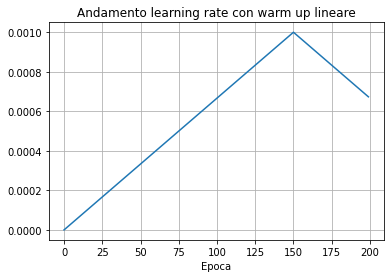

In [20]:
plt.plot(lrs)
plt.grid('on')
plt.xlabel('Epoca')
plt.title('Andamento learning rate con warm up lineare')
None

Il problema è che, nonostante sia applicato warmup, per il soggetto 3 il modello non converge con patch size a 20, ma è necessario portare la patch size a 10 per far sì che il modello converga su tutti i soggetti.

Indipendentemente da questo, vale la pena cercare di capire se con un pretraining di inizializzazione è possibile raggiungere accuratezze migliori.

Sono sperimentati due tipi di pretraining:
 - pretraining su tutti i soggetti + finetuning per ogni soggetto, facendo due run come avviene con training from scratch, cioè 1 con solo ripetizioni pari e uno con solo ripetizioni dispari
 - pretraining sugli altri 9 soggetti + finetuning
 
Per velocizzare le varie grid search, il pretraining è sempre stato fatto sulle ripetizioni dispari (evitando quindi di farne due), quindi viene fatto:
 - pretraining ripetizioni dispari + finetuning ripetizioni dispari
 - retraining ripetizioni dispari + finetuning ripetizioni pari
 - accuratezza sul test come media delle accuratezze ottenute dai due modelli sopra

L'accuratezza media sul test è ancora valida, bisogna solo tenere in conto che seguendo questo ultimo protocollo si ottengono risultati leggermente superiori (circa mezzo punto percentuale) perché il secondo pretraining+finetuning sta vedendo più dati (le ripetizioni dispari in pretraining e le sessioni pari in finetuning)

In [21]:
r = get_rows(all_res_vit, 
                   {'patch_size': 20, 'dim_projection': 64, 'dim_ff': 256, 'dim_head': 32, 'n_heads': 8, 'depth': 1, 'pretraining_dropout': .2})

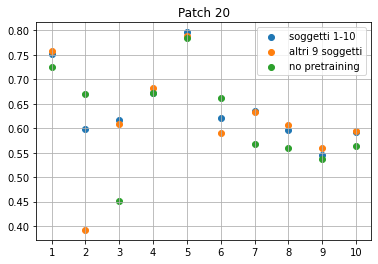

In [22]:
p = {'fold1': 'soggetti 1-10', 'all_others': 'altri 9 soggetti', 'no': 'no pretraining'}
v = {}

for pretraining in ['fold1', 'all_others', 'no']:
    r = get_rows(all_res_vit, 
                   {'pretraining': pretraining, 'patch_size': 20, 'dim_projection': 64, 'dim_ff': 256, 'dim_head': 32, 'n_heads': 8, 'depth': 1, 'pretraining_dropout': .2})
        
    x = [f'test accuracy steady subj{s} avg2folds' for s in range(10)]
    y = r.iloc[0][x]
    
    v[pretraining] = r[[f'test accuracy steady subj{s} avg2folds' for s in [0, 3, 4, 5, 6, 7, 8, 9]]].mean(axis=1, numeric_only=True).iloc[0]
    
    plt.scatter(range(1, 11), y, label=p[pretraining])
    
plt.legend()
plt.grid('on')
plt.xticks(np.arange(1, 11, 1.0))
plt.title('Patch 20')
None

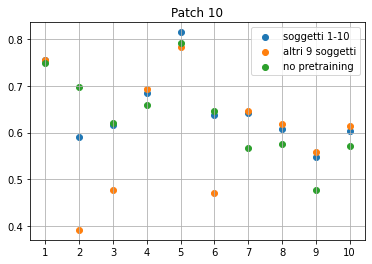

In [23]:
p = {'fold1': 'soggetti 1-10', 'all_others': 'altri 9 soggetti', 'no': 'no pretraining'}
v = {}

for pretraining in ['fold1', 'all_others', 'no']:
    r = get_rows(all_res_vit, 
                   {'pretraining': pretraining, 'patch_size': 10, 'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'n_heads': 8, 'depth': 1, 'pretraining_dropout': .2})
        
    x = [f'test accuracy steady subj{s} avg2folds' for s in range(10)]
    y = r.iloc[0][x]
    
    v[pretraining] = r[[f'test accuracy steady subj{s} avg2folds' for s in [0, 3, 4, 5, 6, 7, 8, 9]]].mean(axis=1, numeric_only=True).iloc[0]
    
    plt.scatter(range(1, 11), y, label=p[pretraining])
    
plt.legend()
plt.grid('on')
plt.xticks(np.arange(1, 11, 1.0))
plt.title('Patch 10')
None

In [24]:
v = r[[f'test accuracy steady subj{s} avg2folds' for s in [0, 3, 4, 5, 6, 7, 8, 9]]].mean(axis=1, numeric_only=True).iloc[0]

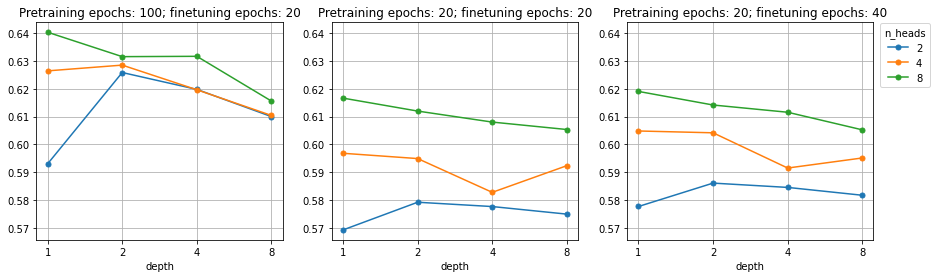

In [25]:
res = get_rows(all_res_vit, 
               {'patch_size': 20, 'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'pretraining_dropout': .2})

fig, ax = plt.subplots(figsize=(15, 4), ncols=3, sharey=True)
ax[1].yaxis.set_tick_params(labelleft=True)
ax[2].yaxis.set_tick_params(labelleft=True)

plot_r(res[(res["pretraining_epochs"] == 100) & (res["finetune_epochs"] == 20)], ax[0], legend=False)
plot_r(res[(res["pretraining_epochs"] == 20) & (res["finetune_epochs"] == 20)], ax[1], legend=False)
plot_r(res[(res["pretraining_epochs"] == 20) & (res["finetune_epochs"] == 40)], ax[2], legend=True)

ax[0].set_title("Pretraining epochs: 100; finetuning epochs: 20")
ax[1].set_title("Pretraining epochs: 20; finetuning epochs: 20")
ax[2].set_title("Pretraining epochs: 20; finetuning epochs: 40")

None

In [26]:
print(res[(res["pretraining_epochs"] == 100) & (res["finetune_epochs"] == 20)].groupby('depth').mean()[['params', 'MACs', 'test accuracy steady avg2folds']])
print(res[(res["pretraining_epochs"] == 20) & (res["finetune_epochs"] == 20)].groupby('depth').mean()['params', 'MACs', 'test accuracy steady avg2folds'])
print(res[(res["pretraining_epochs"] == 20) & (res["finetune_epochs"] == 40)].groupby('depth').mean()['params', 'MACs', 'test accuracy steady avg2folds'])

              params       MACs  test accuracy steady avg2folds
depth                                                          
1       60765.333333  1219584.0                        0.619898
2      115890.666667  2169856.0                        0.628587
4      226141.333333  4070400.0                        0.623662
8      446642.666667  7871488.0                        0.611980


KeyError: ('params', 'MACs', 'test accuracy steady avg2folds')

In [ ]:
print(res[(res["pretraining_epochs"] == 100) & (res["finetune_epochs"] == 20)].mean()[['params', 'MACs', 'validation accuracy steady fold1', 'test accuracy steady avg2folds']])
print(res[(res["pretraining_epochs"] == 20) & (res["finetune_epochs"] == 20)].mean()[['params', 'MACs', 'validation accuracy steady fold1', 'test accuracy steady avg2folds']])
print(res[(res["pretraining_epochs"] == 20) & (res["finetune_epochs"] == 40)].mean()[['params', 'MACs', 'validation accuracy steady fold1', 'test accuracy steady avg2folds']])

In [ ]:
r = get_rows(all_res_vit, 
               {'patch_size': 20, 'dim_projection': 64, 'dim_ff': 256, 'dim_head': 32, 'n_heads': 8, 'depth': 1, 'pretraining_dropout': .2})

res_p = {
    'pretraining': .5 * (float(r[r['pretraining'] == 'fold1']['test accuracy steady fold1']) + float(r[r['pretraining'] == 'fold2']['test accuracy steady fold2'])),
    'pretraining\nsolo fold1\nft fold1': (float(r[r['pretraining'] == 'fold1']['test accuracy steady fold1'])),
    'pretraining\nsolo fold2\nft fold2': (float(r[r['pretraining'] == 'fold2']['test accuracy steady fold2'])),
    'pretraining\nrep. opposte': .5 * (float(r[r['pretraining'] == 'fold2']['test accuracy steady fold1']) + float(r[r['pretraining'] == 'fold1']['test accuracy steady fold2'])),
    'pretraining\nsolo fold1\nft fold2': (float(r[r['pretraining'] == 'fold1']['test accuracy steady fold2'])),
    'pretraining\nsolo fold2\nft fold1': (float(r[r['pretraining'] == 'fold2']['test accuracy steady fold1'])),
    'pretraining\nsolo fold1\nft avg2folds': (float(r[r['pretraining'] == 'fold1']['test accuracy steady avg2folds'])),
    'pretraining\nsolo fold2\nft avg2folds': (float(r[r['pretraining'] == 'fold2']['test accuracy steady avg2folds'])),
    'pretrain\naltri\nsoggetti': float(r[r['pretraining'] == 'all_others']['test accuracy steady avg2folds']),
    'no pretraining': float(r[r['pretraining'] == 'no']['test accuracy steady avg2folds']),
}

x, y = [], []
for xx, yy in res_p.items():
    x.append(xx)
    y.append(yy)

x = np.array(x)
y = np.array(y)

fig, ax = plt.subplots(figsize=(14, 3), ncols=3, sharey=True)
[a.grid('on') for a in ax]
[a.yaxis.set_tick_params(labelleft=True) for a in ax]
ax[0].scatter(x[:3], y[:3])
ax[1].scatter(x[3:6], y[3:6])
ax[2].scatter(x[6:], y[6:])

r

fig, ax = plt.subplots(figsize=(10, 3), ncols=2, sharey=True)
fig.suptitle('VIT - PATCH 20')
[a.grid('on') for a in ax]
[a.yaxis.set_tick_params(labelleft=True) for a in ax]
ax[0].scatter(x[:3], y[:3])
ax[1].scatter(x[3:6], y[3:6])


In [ ]:
r = get_rows(all_res_vit, 
               {'patch_size': 10, 'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'n_heads': 8, 'depth': 1, 'pretraining_dropout': .2})

res_p = {
    'pretraining': .5 * (float(r[r['pretraining'] == 'fold1']['test accuracy steady fold1']) + float(r[r['pretraining'] == 'fold2']['test accuracy steady fold2'])),
    'pretraining\nsolo fold1\nft fold1': (float(r[r['pretraining'] == 'fold1']['test accuracy steady fold1'])),
    'pretraining\nsolo fold2\nft fold2': (float(r[r['pretraining'] == 'fold2']['test accuracy steady fold2'])),
    'pretraining\nrep. opposte': .5 * (float(r[r['pretraining'] == 'fold2']['test accuracy steady fold1']) + float(r[r['pretraining'] == 'fold1']['test accuracy steady fold2'])),
    'pretraining\nsolo fold1\nft fold2': (float(r[r['pretraining'] == 'fold1']['test accuracy steady fold2'])),
    'pretraining\nsolo fold2\nft fold1': (float(r[r['pretraining'] == 'fold2']['test accuracy steady fold1'])),
    'pretraining\nsolo fold1\nft avg2folds': (float(r[r['pretraining'] == 'fold1']['test accuracy steady avg2folds'])),
    'pretraining\nsolo fold2\nft avg2folds': (float(r[r['pretraining'] == 'fold2']['test accuracy steady avg2folds'])),
    'pretrain\naltri\nsoggetti': float(r[r['pretraining'] == 'all_others']['test accuracy steady avg2folds']),
    'no pretraining': float(r[r['pretraining'] == 'no']['test accuracy steady avg2folds']),
}

x, y = [], []
for xx, yy in res_p.items():
    x.append(xx)
    y.append(yy)

x = np.array(x)
y = np.array(y)

fig, ax = plt.subplots(figsize=(14, 3), ncols=3, sharey=True)
[a.grid('on') for a in ax]
[a.yaxis.set_tick_params(labelleft=True) for a in ax]
ax[0].scatter(x[:3], y[:3])
ax[1].scatter(x[3:6], y[3:6])
ax[2].scatter(x[6:], y[6:])

r

fig, ax = plt.subplots(figsize=(10, 3), ncols=2, sharey=True)
fig.suptitle('VIT - PATCH 10')
[a.grid('on') for a in ax]
[a.yaxis.set_tick_params(labelleft=True) for a in ax]
ax[0].scatter(x[:3], y[:3])
ax[1].scatter(x[3:6], y[3:6])

In [ ]:
r = all_res_tcn

res_p = {
    'pretraining': .5 * (float(r[r['pretraining'] == 'fold1']['test accuracy steady fold1']) + float(r[r['pretraining'] == 'fold2']['test accuracy steady fold2'])),
    'pretraining\nsolo fold1\nft fold1': (float(r[r['pretraining'] == 'fold1']['test accuracy steady fold1'])),
    'pretraining\nsolo fold2\nft fold2': (float(r[r['pretraining'] == 'fold2']['test accuracy steady fold2'])),
    'pretraining\nrep. opposte': .5 * (float(r[r['pretraining'] == 'fold2']['test accuracy steady fold1']) + float(r[r['pretraining'] == 'fold1']['test accuracy steady fold2'])),
    'pretraining\nsolo fold1\nft fold2': (float(r[r['pretraining'] == 'fold1']['test accuracy steady fold2'])),
    'pretraining\nsolo fold2\nft fold1': (float(r[r['pretraining'] == 'fold2']['test accuracy steady fold1'])),
    'pretraining\nsolo fold1\nft avg2folds': (float(r[r['pretraining'] == 'fold1']['test accuracy steady avg2folds'])),
    'pretraining\nsolo fold2\nft avg2folds': (float(r[r['pretraining'] == 'fold2']['test accuracy steady avg2folds'])),
    'no pretraining': float(r[r['pretraining'] == 'no']['test accuracy steady avg2folds']),
}

x, y = [], []
for xx, yy in res_p.items():
    x.append(xx)
    y.append(yy)

x = np.array(x)
y = np.array(y)

fig, ax = plt.subplots(figsize=(14, 3), ncols=3, sharey=True)
[a.grid('on') for a in ax]
[a.yaxis.set_tick_params(labelleft=True) for a in ax]
ax[0].scatter(x[:3], y[:3])
ax[1].scatter(x[3:6], y[3:6])
ax[2].scatter(x[6:], y[6:])

r

fig, ax = plt.subplots(figsize=(10, 3), ncols=2, sharey=True)
fig.suptitle('TEMPONET')
[a.grid('on') for a in ax]
[a.yaxis.set_tick_params(labelleft=True) for a in ax]
ax[0].scatter(x[:3], y[:3])
ax[1].scatter(x[3:6], y[3:6])

In [ ]:
res = get_rows(all_res_vit, 
               {'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'pretraining_dropout': .2, 'pretraining_epochs': 100, 'pretraining': 'fold1'})

res = res[res["patch_size"] >= 10]

fig, ax = plt.subplots(figsize=(15, 4), ncols=3, sharey=True)
ax[1].yaxis.set_tick_params(labelleft=True)
ax[2].yaxis.set_tick_params(labelleft=True)

plot_r(res[(res["patch_size"] == 10)], ax[0], legend=False)
plot_r(res[(res["patch_size"] == 20)], ax[1], legend=False)
plot_r(res[(res["patch_size"] == 30)], ax[2], legend=True)

ax[0].set_title("Patch 10")
ax[1].set_title("Patch 20")
ax[2].set_title("Patch 30")

None

In [27]:
res = get_rows(all_res_vit, {'patch_size': 20, 'dim_projection': 64, 'dim_ff': 256, 
                             'pretraining': 'fold1', 'pretraining_dropout': .2, 'pretraining_epochs': 100})

res_ = res[res['depth'].isin([1, 2]) & res['n_heads'].isin([2, 4, 8])][['n_heads', 'depth', 'dim_head', 'test accuracy steady avg2folds', 'validation accuracy steady fold1']]
res__ = res_.groupby('dim_head').agg(['min', 'max', 'mean'])[['validation accuracy steady fold1', 'test accuracy steady avg2folds']]

display(res__)
print(res__.to_latex(index=True))  

#display(res_.sort_values(['dim_head', 'depth', 'n_heads']))
#print(res_.to_latex(index=False))  

validation accuracy steady fold1                      \
                                      min       max      mean   
dim_head                                                        
16                               0.628670  0.703704  0.676824   
32                               0.631735  0.699998  0.679062   
64                               0.629874  0.707415  0.680656   

         test accuracy steady avg2folds                      
                                    min       max      mean  
dim_head                                                     
16                             0.592398  0.637153  0.622521  
32                             0.593883  0.642666  0.624112  
64                             0.594235  0.639759  0.625326

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{validation accuracy steady fold1} & \multicolumn{3}{l}{test accuracy steady avg2folds} \\
{} &                              min &       max &      mean &                            min &       max &      mean \\
dim\_head &                                  &           &           &                                &           &           \\
\midrule
16       &                         0.628670 &  0.703704 &  0.676824 &                       0.592398 &  0.637153 &  0.622521 \\
32       &                         0.631735 &  0.699998 &  0.679062 &                       0.593883 &  0.642666 &  0.624112 \\
64       &                         0.629874 &  0.707415 &  0.680656 &                       0.594235 &  0.639759 &  0.625326 \\
\bottomrule
\end{tabular}



In [ ]:
res[['n_heads', 'depth', 'dim_head', 'params', 'validation accuracy steady fold1']].sort_values(['n_heads', 'depth', 'dim_head'])

In [ ]:
rres = res[(res['depth'] == 1)][['params', 'dim_head', 'validation accuracy steady fold1', 'test accuracy steady avg2folds',]].sort_values(['params'])

for i, a in enumerate([16, 32, 64]):
    plt.scatter(rres[rres['dim_head'] == a]['params'], rres[rres['dim_head'] == a]['validation accuracy steady fold1'], c=f'C{i}', label=a)
plt.legend()

In [30]:
res[res['depth'] == 2][['params', 'dim_head', 'n_heads', 'depth', 'validation accuracy steady fold1', 'test accuracy steady avg2folds',]].sort_values(['params']).to_csv()

',params,dim_head,n_heads,depth,validation accuracy steady fold1,test accuracy steady avg2folds\r\n155,88840,16,2,2,0.6778977572917938,0.6225630700588226\r\n83,105224,32,2,2,0.682633763551712,0.6245020300149917\r\n156,105224,16,4,2,0.6952627778053284,0.6285579246282577\r\n84,137992,32,4,2,0.6976405322551728,0.6312036895751953\r\n143,137992,64,2,2,0.6837531924247742,0.6297029215097427\r\n157,137992,16,8,2,0.7037039995193481,0.6318424534797668\r\n85,203528,32,8,2,0.6999975800514221,0.6292640793323517\r\n144,203528,64,4,2,0.6987134158611298,0.631603661775589\r\n145,334600,64,8,2,0.7074149370193481,0.6311349242925643\r\n'

In [ ]:
res_untrained = get_rows(all_res_vit_2, 
               {'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'n_heads': 2, 'depth': 2,
                'pretraining': False})

res_untrained = get_rows(all_res_vit, 
               {'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'n_heads': 8, 'depth': 1,
                'pretraining_dropout': .2, 'pretraining_epochs': 100, 'pretraining': 'fold1'})
res_untrained[['patch_size', 'MACs', 'validation accuracy steady fold1', 'test accuracy steady avg2folds',]].to_csv()

In [ ]:
res_untrained

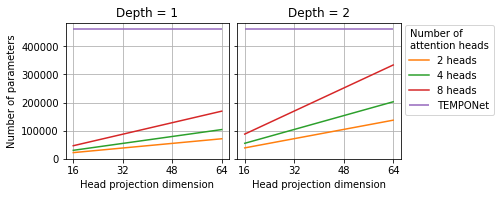

In [31]:
tcn = all_res_tcn.loc[all_res_tcn[all_res_tcn['pretraining'] == 'fold1'].index[0]]
tcn_macs, tcn_params, tcn_test_accuracy_steady_avg2folds = tcn['MACs'], tcn['params'], tcn['test accuracy steady avg2folds']


#attention_params = lambda c, d, n_h: 3*c + c*d*n_h*4
attention_params = lambda c, d, n_h, depth: sum([param.nelement() for param in ViT(image_size=(1, 300), patch_size=(1, 10), dim=c, dim_head=d, heads=n_h, mlp_dim=d*4, depth=depth, num_classes=8).parameters()])

x=np.array([16, 32, 64])

fig, ax = plt.subplots(figsize=(6, 2.5), ncols=2, sharey=True, gridspec_kw={'wspace': 0.05})
#ax[1].yaxis.set_tick_params(labelleft=True)

ax[0].plot(x, [attention_params(c=64, d=a, n_h=2, depth=1) for a in x], label='2 heads', color='C1',)
ax[1].plot(x, [attention_params(c=64, d=a, n_h=2, depth=2) for a in x], label='2 heads', color='C1',)

ax[0].plot(x, [attention_params(c=64, d=a, n_h=4, depth=1) for a in x], label='4 heads', color='C2',)
ax[1].plot(x, [attention_params(c=64, d=a, n_h=4, depth=2) for a in x], label='4 heads', color='C2',)

ax[0].plot(x, [attention_params(c=64, d=a, n_h=8, depth=1) for a in x], label='8 heads', color='C3')
ax[1].plot(x, [attention_params(c=64, d=a, n_h=8, depth=2) for a in x], label='8 heads', color='C3',)


for a in ax:
    a.hlines(tcn_params, 16, 64, color='C4', label='TEMPONet')
    a.set_xticks(np.arange(16, 65, 16))
    a.grid()
    a.set_xlabel("Head projection dimension")
ax[0].set_ylabel("Number of parameters")

ax[1].legend(title="Number of\nattention heads", loc="upper right", bbox_to_anchor=(1.6, 1.02))

ax[0].set_title("Depth = 1")
ax[1].set_title("Depth = 2")

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [61]:
[attention_params(c=64, d=a, n_h=8, depth=2) for a in [16, 32, 64]]

[87496, 169544, 333640]

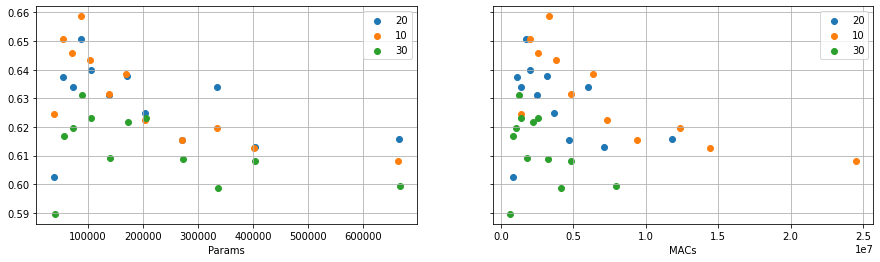

In [28]:
res.loc[res['patch_size'] == 10, "label"] = "10"
res.loc[(res['patch_size'] == 20), "label"] = "20"
res.loc[(res['patch_size'] == 30), "label"] = "30"

fig, ax = plt.subplots(figsize=(15, 4), ncols=2, sharey=True)

for label in res["label"].unique():
    sc = ax[0].scatter(res[res["label"] == label]["params"], res[res["label"] == label]["test accuracy steady fold1"], label=label)
ax[0].legend()
ax[0].set_xlabel("Params")
ax[0].grid("on")

for label in res["label"].unique():
    sc = ax[1].scatter(res[res["label"] == label]["MACs"], res[res["label"] == label]["test accuracy steady fold1"], label=label)
ax[1].legend()
ax[1].set_xlabel("MACs")
ax[1].grid("on")

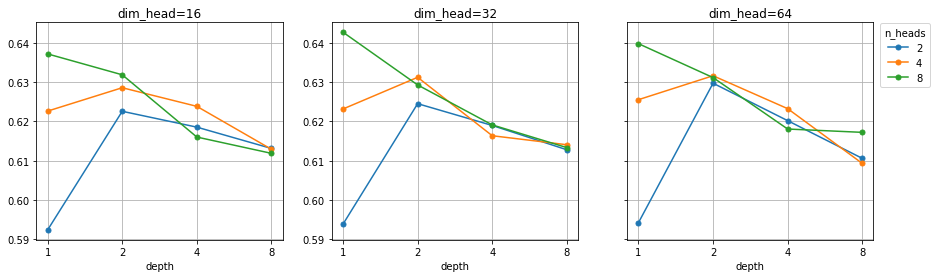

In [20]:
res = get_rows(all_res_vit, {'patch_size': 20, 'dim_projection': 64, 'dim_ff': 256, 
                             'pretraining': 'fold1', 'pretraining_dropout': .2, 'pretraining_epochs': 100})

fig, ax = plt.subplots(figsize=(15, 4), ncols=3, sharey=True)
ax[1].yaxis.set_tick_params(labelleft=True)

plot_r(res[(res["dim_head"] == 16)], ax[0], legend=False)
plot_r(res[(res["dim_head"] == 32)], ax[1], legend=False)
plot_r(res[(res["dim_head"] == 64)], ax[2], legend=True)

ax[0].set_title("dim_head=16")
ax[1].set_title("dim_head=32")
ax[2].set_title("dim_head=64")

None

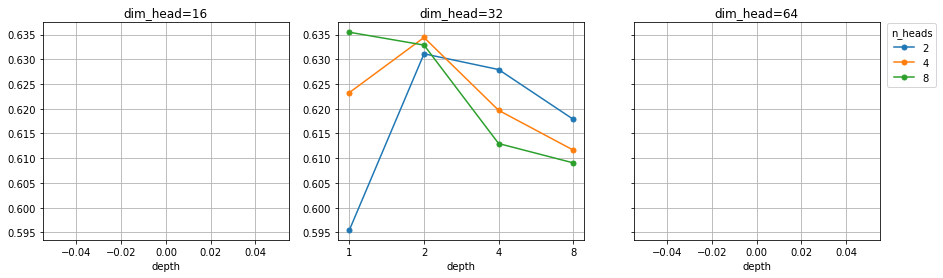

In [18]:
res = get_rows(all_res_vit, {'patch_size': 20, 'dim_projection': 128, 'dim_ff': 256,
                             'pretraining': 'fold1', 'pretraining_dropout': .2, 'pretraining_epochs': 100})

fig, ax = plt.subplots(figsize=(15, 4), ncols=3, sharey=True)
ax[1].yaxis.set_tick_params(labelleft=True)

plot_r(res[(res["dim_head"] == 16)], ax[0], legend=False)
plot_r(res[(res["dim_head"] == 32)], ax[1], legend=False)
plot_r(res[(res["dim_head"] == 64)], ax[2], legend=True)

ax[0].set_title("dim_head=16")
ax[1].set_title("dim_head=32")
ax[2].set_title("dim_head=64")

None

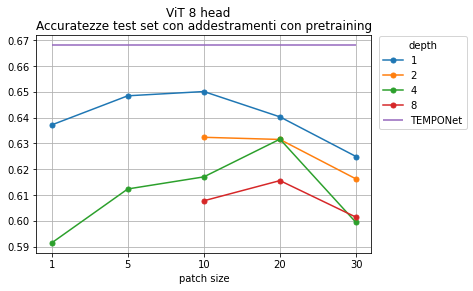

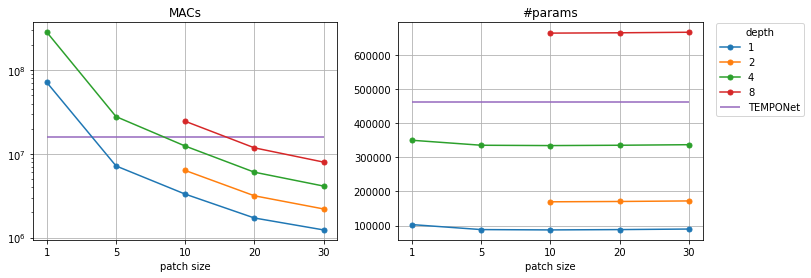

In [30]:
tcn = all_res_tcn.loc[all_res_tcn[all_res_tcn['pretraining'] == 'fold1'].index[0]]
tcn_macs, tcn_params, tcn_test_accuracy_steady_avg2folds = tcn['MACs'], tcn['params'], tcn['test accuracy steady avg2folds']

res_ = get_rows(all_res_vit, 
               {'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'n_heads': 8, 
                'pretraining_dropout': .2, 'pretraining_epochs': 100, 'pretraining': 'fold1'})

res_ = res_.sort_values(by=['patch_size'])

for depth in [1, 2, 4, 8]:
    r = res_[res_['depth'] == depth]
    plt.plot([str(x) for x in r['patch_size']], r['test accuracy steady avg2folds'], marker='.', markersize=10, label=depth)

plt.hlines(tcn_test_accuracy_steady_avg2folds, 0, 4, color='C4', label='TEMPONet')
plt.grid('on')
plt.xlabel('patch size')
plt.suptitle('ViT 8 head')
plt.title('Accuratezze test set con addestramenti con pretraining')
plt.legend(title="depth", loc="upper right", bbox_to_anchor=(1.3, 1.02))
plt.show()

fig, ax = plt.subplots(figsize=(12,4), ncols=2)
for depth in [1, 2, 4, 8]:
    r = res_[res_['depth'] == depth]
    ax[0].plot([str(x) for x in r['patch_size']], r['MACs'], marker='.', markersize=10, label=depth)
    ax[1].plot([str(x) for x in r['patch_size']], r['params'], marker='.', markersize=10, label=depth)
    
ax[0].hlines(tcn_macs, 0, 4, color='C4', label='TEMPONet')
ax[1].hlines(tcn_params, 0, 4, color='C4', label='TEMPONet')
ax[0].set_yscale('log')
[a.grid('on') for a in ax]
[a.set_xlabel('patch size') for a in ax]
ax[0].set_title('MACs')
ax[1].set_title('#params')
plt.legend(title="depth", loc="upper right", bbox_to_anchor=(1.35, 1.02))
None

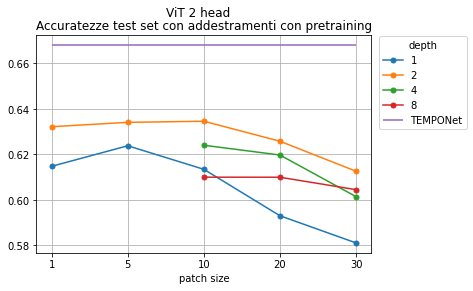

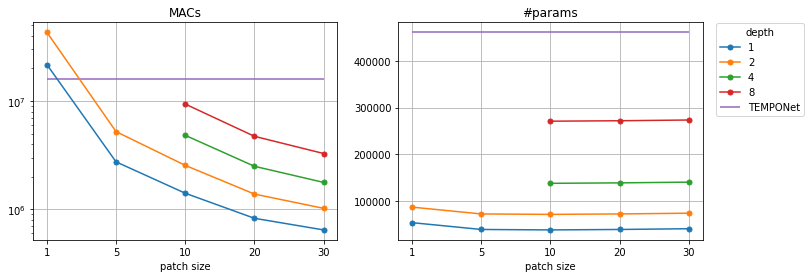

In [31]:
tcn = all_res_tcn.loc[all_res_tcn[all_res_tcn['pretraining'] == 'fold1'].index[0]]
tcn_macs, tcn_params, tcn_test_accuracy_steady_avg2folds = tcn['MACs'], tcn['params'], tcn['test accuracy steady avg2folds']

res_ = get_rows(all_res_vit, 
               {'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'n_heads': 2, 
                'pretraining_dropout': .2, 'pretraining_epochs': 100, 'pretraining': 'fold1'})

res_ = res_.sort_values(by=['patch_size'])

for depth in [1, 2, 4, 8]:
    r = res_[res_['depth'] == depth]
    plt.plot([str(x) for x in r['patch_size']], list(r['test accuracy steady avg2folds']), marker='.', markersize=10, label=depth)

plt.hlines(tcn_test_accuracy_steady_avg2folds, 0, 4, color='C4', label='TEMPONet')
plt.grid('on')
plt.xlabel('patch size')
plt.suptitle('ViT 2 head')
plt.title('Accuratezze test set con addestramenti con pretraining')
plt.legend(title="depth", loc="upper right", bbox_to_anchor=(1.3, 1.02))
plt.show()

fig, ax = plt.subplots(figsize=(12,4), ncols=2)
for depth in [1, 2, 4, 8]:
    r = res_[res_['depth'] == depth]
    vit_1 = vit(patch_size=1, dim=64, dim_head=32, n_heads=2, mlp_dim=128, depth=depth)
    vit_5 = vit(patch_size=5, dim=64, dim_head=32, n_heads=2, mlp_dim=128, depth=depth)
    ax[0].plot([str(x) for x in r['patch_size']], list(r['MACs']), marker='.', markersize=10, label=depth)
    ax[1].plot([str(x) for x in r['patch_size']], list(r['params']), marker='.', markersize=10, label=depth)
    
ax[0].hlines(tcn_macs, 0, 4, color='C4', label='TEMPONet')
ax[1].hlines(tcn_params, 0, 4, color='C4', label='TEMPONet')
ax[0].set_yscale('log')
[a.grid('on') for a in ax]
[a.set_xlabel('patch size') for a in ax]
ax[0].set_title('MACs')
ax[1].set_title('#params')
plt.legend(title="depth", loc="upper right", bbox_to_anchor=(1.35, 1.02))
None

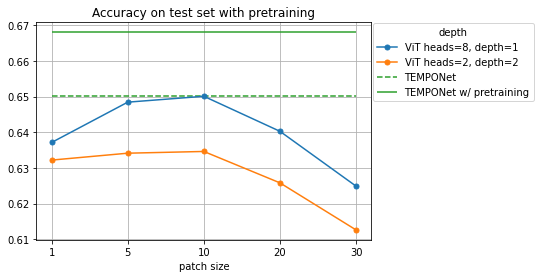

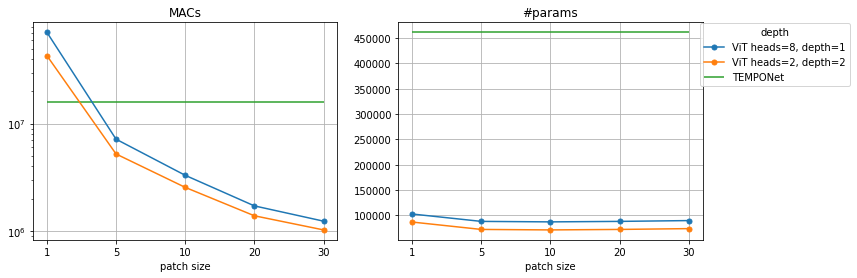

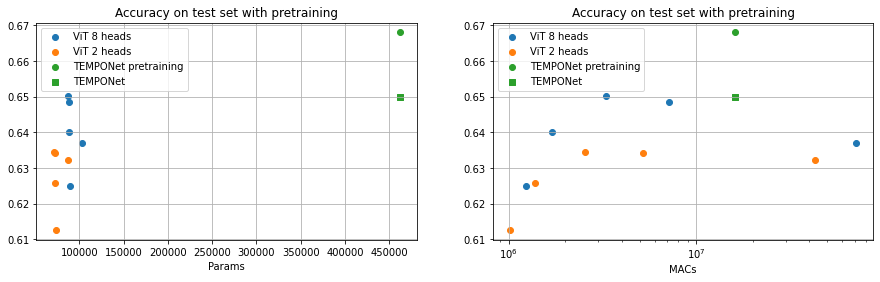

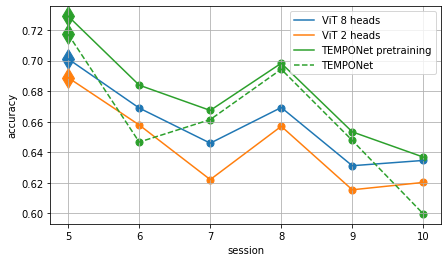

In [32]:
tcn = all_res_tcn.loc[all_res_tcn[all_res_tcn['pretraining'] == 'fold1'].index[0]]
tcn_macs, tcn_params, tcn_test_accuracy_steady_avg2folds = tcn['MACs'], tcn['params'], tcn['test accuracy steady avg2folds']
tcn_nop = all_res_tcn.loc[all_res_tcn[all_res_tcn['pretraining'] == 'no'].index[0]]
tcn_macs, tcn_params, tcn_test_accuracy_steady_avg2folds_nop = tcn['MACs'], tcn['params'], tcn_nop['test accuracy steady avg2folds']

res_ = get_rows(all_res_vit, 
               {'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'n_heads': 8, 'depth': 1,
                'pretraining_dropout': .2, 'pretraining_epochs': 100, 'pretraining': 'fold1'}) \
        .append(get_rows(all_res_vit, 
               {'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'n_heads': 2, 'depth': 2,
                'pretraining_dropout': .2, 'pretraining_epochs': 100, 'pretraining': 'fold1'}))

res_ = res_.sort_values(by=['patch_size']).copy()

for depth in [1, 2]:
    r = res_[res_['depth'] == depth]
    plt.plot([str(x) for x in r['patch_size']], list(r['test accuracy steady avg2folds']), marker='.', markersize=10, label=f"ViT heads={8 if depth == 1 else 2}, depth={depth}")

plt.hlines(tcn_test_accuracy_steady_avg2folds_nop, 0, 4, linestyle='--', color='C2', label='TEMPONet')
plt.hlines(tcn_test_accuracy_steady_avg2folds, 0, 4, color='C2', label='TEMPONet w/ pretraining')
plt.grid('on')
plt.xlabel('patch size')
#plt.suptitle('ViT 2 head')
plt.title('Accuracy on test set with pretraining')
#plt.legend(title="depth", loc="upper right", bbox_to_anchor=(1.3, 1.02))
plt.legend(title="depth", loc="upper right", bbox_to_anchor=(1.5, 1.02))
plt.show()

fig, ax = plt.subplots(figsize=(12,4), ncols=2)
for depth in [1, 2]:
    r = res_[res_['depth'] == depth]
    ax[0].plot([str(x) for x in r['patch_size']], list(r['MACs']), marker='.', markersize=10, label=f"ViT heads={8 if depth == 1 else 2}, depth={depth}")
    ax[1].plot([str(x) for x in r['patch_size']], list(r['params']), marker='.', markersize=10, label=f"ViT heads={8 if depth == 1 else 2}, depth={depth}")
    
ax[0].hlines(tcn_macs, 0, 4, color='C2', label='TEMPONet')
ax[1].hlines(tcn_params, 0, 4, color='C2', label='TEMPONet')
ax[0].set_yscale('log')
[a.grid('on') for a in ax]
[a.set_xlabel('patch size') for a in ax]
ax[0].set_title('MACs')
ax[1].set_title('#params')
#plt.legend(title="depth", loc="upper right", bbox_to_anchor=(1.35, 1.02))
plt.legend(title="depth", loc="upper right", bbox_to_anchor=(1.5, 1.02))

fig, ax = plt.subplots(figsize=(15, 4), ncols=2, sharey=True)
ax[1].yaxis.set_tick_params(labelleft=True)

res_.loc[res_['depth'] == 1, "label"] = "ViT 8 heads"
res_.loc[res_['depth'] == 2, "label"] = "ViT 2 heads"
for label in res_["label"].unique():
    sc = ax[0].scatter(res_[res_["label"] == label]["params"], res_[res_["label"] == label]["test accuracy steady avg2folds"], label=label)
ax[0].scatter([tcn_params], [tcn_test_accuracy_steady_avg2folds], color='C2', label='TEMPONet pretraining')
ax[0].scatter([tcn_params], [tcn_test_accuracy_steady_avg2folds_nop], color='C2', label='TEMPONet', marker='s')
ax[0].legend()
ax[0].set_title('Accuracy on test set with pretraining')
ax[0].set_xlabel("Params")
ax[0].grid("on")

for label in res_["label"].unique():
    sc = ax[1].scatter(res_[res_["label"] == label]["MACs"], res_[res_["label"] == label]["test accuracy steady avg2folds"], label=label)
ax[1].scatter([tcn_macs], [tcn_test_accuracy_steady_avg2folds], color='C2', label='TEMPONet pretraining')
ax[1].scatter([tcn_macs], [tcn_test_accuracy_steady_avg2folds_nop], color='C2', label='TEMPONet', marker='s')
ax[1].legend()
ax[1].set_xlabel("MACs")
ax[1].set_xscale('log')
ax[1].grid("on")
ax[1].set_title('Accuracy on test set with pretraining')

fig, ax = plt.subplots(figsize=(7, 4))

r = res_[(res_['depth'] == 1) & (res_['patch_size'] == 10)].iloc[0]
acccs = [r['validation accuracy steady fold1']] + [r[f'test accuracy steady session{s} avg2folds'] for s in [6, 7, 8, 9, 10]]

x = list(range(5, 11))
y = [a for a in acccs]
m = ['d'] + (['o'] * (len(x) - 1))
s = [200] + [50] * (len(x) - 1)

ax.plot(x, y, color=f'C0', label='ViT 8 heads')
for xp, yp, m_, s_ in zip(x, y, m, s):
    ax.scatter([xp],[float(yp)], marker=m_, s=s_, color=f'C0')
    
r = res_[(res_['depth'] == 2) & (res_['patch_size'] == 10)].iloc[0]
acccs = [r['validation accuracy steady fold1']] + [r[f'test accuracy steady session{s} avg2folds'] for s in [6, 7, 8, 9, 10]]

x = list(range(5, 11))
y = [a for a in acccs]
m = ['d'] + (['o'] * (len(x) - 1))
s = [200] + [50] * (len(x) - 1)

ax.plot(x, y, color=f'C1', label='ViT 2 heads')
for xp, yp, m_, s_ in zip(x, y, m, s):
    ax.scatter([xp],[float(yp)], marker=m_, s=s_, color=f'C1')
    
r = tcn
acccs = [r['validation accuracy steady fold1']] + [r[f'test accuracy steady session{s} avg2folds'] for s in [6, 7, 8, 9, 10]]

x = list(range(5, 11))
y = [a for a in acccs]
m = ['d'] + (['o'] * (len(x) - 1))
s = [200] + [50] * (len(x) - 1)

ax.plot(x, y, color=f'C2', label='TEMPONet pretraining')
for xp, yp, m_, s_ in zip(x, y, m, s):
    ax.scatter([xp],[float(yp)], marker=m_, s=s_, color=f'C2')

ax.set_xlabel("session")
ax.set_ylabel("accuracy")
ax.grid('on')
ax.legend()

r = tcn_nop
acccs = [r['validation accuracy steady fold1']] + [r[f'test accuracy steady session{s} avg2folds'] for s in [6, 7, 8, 9, 10]]

x = list(range(5, 11))
y = [a for a in acccs]
m = ['d'] + (['o'] * (len(x) - 1))
s = [200] + [50] * (len(x) - 1)

ax.plot(x, y, color=f'C2', label='TEMPONet', linestyle='--')
for xp, yp, m_, s_ in zip(x, y, m, s):
    ax.scatter([xp],[float(yp)], marker=m_, s=s_, color=f'C2')

ax.set_xlabel("session")
ax.set_ylabel("accuracy")
ax.grid('on')
ax.legend()

None

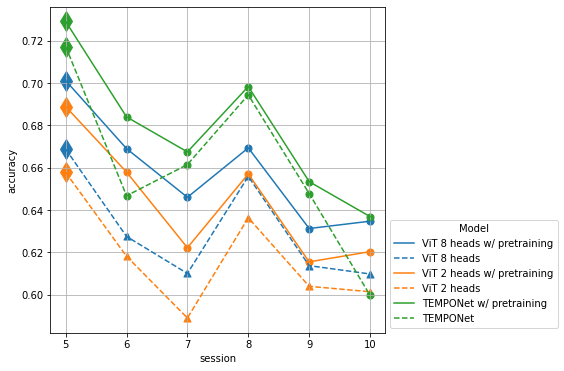

In [98]:
tcn = all_res_tcn.loc[all_res_tcn[all_res_tcn['pretraining'] == 'fold1'].index[0]]
tcn_macs, tcn_params, tcn_test_accuracy_steady_avg2folds = tcn['MACs'], tcn['params'], tcn['test accuracy steady avg2folds']
tcn_nop = all_res_tcn.loc[all_res_tcn[all_res_tcn['pretraining'] == 'no'].index[0]]
tcn_macs, tcn_params, tcn_test_accuracy_steady_avg2folds_nop = tcn['MACs'], tcn['params'], tcn_nop['test accuracy steady avg2folds']

res_ = get_rows(all_res_vit, 
               {'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'n_heads': 8, 'depth': 1,
                'pretraining_dropout': .2, 'pretraining_epochs': 100, 'pretraining': 'fold1'}) \
        .append(get_rows(all_res_vit, 
               {'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'n_heads': 2, 'depth': 2,
                'pretraining_dropout': .2, 'pretraining_epochs': 100, 'pretraining': 'fold1'}))

res_ = res_.sort_values(by=['patch_size']).copy()

res_untrained = get_rows(all_res_vit_2, 
               {'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'n_heads': 8, 'depth': 1,
                'pretraining': False}) \
        .append(get_rows(all_res_vit_2, 
               {'dim_projection': 64, 'dim_ff': 128, 'dim_head': 32, 'n_heads': 2, 'depth': 2,
                'pretraining': False}))

res_untrained = res_untrained.sort_values(by=['patch_size']).copy()




#################

fig, ax = plt.subplots(figsize=(6, 6))

### 8

r = res_[(res_['depth'] == 1) & (res_['patch_size'] == 10)].iloc[0]
acccs = [r['validation accuracy steady fold1']] + [r[f'test accuracy steady session{s} avg2folds'] for s in [6, 7, 8, 9, 10]]

x = list(range(5, 11))
y = [a for a in acccs]
m = ['d'] + (['o'] * (len(x) - 1))
s = [200] + [50] * (len(x) - 1)

ax.plot(x, y, color=f'C0', label='ViT 8 heads w/ pretraining')
for xp, yp, m_, s_ in zip(x, y, m, s):
    ax.scatter([xp],[float(yp)], marker=m_, s=s_, color=f'C0')

r = res_untrained[(res_untrained['depth'] == 1) & (res_untrained['patch_size'] == 10)].iloc[0]
acccs = [r['validation accuracy steady fold1']] + [r[f'test accuracy steady session{s} avg2folds'] for s in [6, 7, 8, 9, 10]]

x = list(range(5, 11))
y = [a for a in acccs]
m = ['d'] + (['^'] * (len(x) - 1))
s = [200] + [50] * (len(x) - 1)

ax.plot(x, y, color=f'C0', label='ViT 8 heads', linestyle='--')
for xp, yp, m_, s_ in zip(x, y, m, s):
    ax.scatter([xp],[float(yp)], marker=m_, s=s_, color=f'C0')
    
### 2
    
r = res_[(res_['depth'] == 2) & (res_['patch_size'] == 10)].iloc[0]
acccs = [r['validation accuracy steady fold1']] + [r[f'test accuracy steady session{s} avg2folds'] for s in [6, 7, 8, 9, 10]]

x = list(range(5, 11))
y = [a for a in acccs]
m = ['d'] + (['o'] * (len(x) - 1))
s = [200] + [50] * (len(x) - 1)

ax.plot(x, y, color=f'C1', label='ViT 2 heads w/ pretraining')
for xp, yp, m_, s_ in zip(x, y, m, s):
    ax.scatter([xp],[float(yp)], marker=m_, s=s_, color=f'C1')
    
r = res_untrained[(res_untrained['depth'] == 2) & (res_untrained['patch_size'] == 10)].iloc[0]
acccs = [r['validation accuracy steady fold1']] + [r[f'test accuracy steady session{s} avg2folds'] for s in [6, 7, 8, 9, 10]]

x = list(range(5, 11))
y = [a for a in acccs]
m = ['d'] + (['^'] * (len(x) - 1))
s = [200] + [50] * (len(x) - 1)

ax.plot(x, y, color=f'C1', label='ViT 2 heads', linestyle='--')
for xp, yp, m_, s_ in zip(x, y, m, s):
    ax.scatter([xp],[float(yp)], marker=m_, s=s_, color=f'C1')
    
r = tcn
acccs = [r['validation accuracy steady fold1']] + [r[f'test accuracy steady session{s} avg2folds'] for s in [6, 7, 8, 9, 10]]

x = list(range(5, 11))
y = [a for a in acccs]
m = ['d'] + (['o'] * (len(x) - 1))
s = [200] + [50] * (len(x) - 1)

ax.plot(x, y, color=f'C2', label='TEMPONet w/ pretraining')
for xp, yp, m_, s_ in zip(x, y, m, s):
    ax.scatter([xp],[float(yp)], marker=m_, s=s_, color=f'C2')

ax.set_xlabel("session")
ax.set_ylabel("accuracy")
ax.grid('on')
ax.legend()

r = tcn_nop
acccs = [r['validation accuracy steady fold1']] + [r[f'test accuracy steady session{s} avg2folds'] for s in [6, 7, 8, 9, 10]]

x = list(range(5, 11))
y = [a for a in acccs]
m = ['d'] + (['o'] * (len(x) - 1))
s = [200] + [50] * (len(x) - 1)

ax.plot(x, y, color=f'C2', label='TEMPONet', linestyle='--')
for xp, yp, m_, s_ in zip(x, y, m, s):
    ax.scatter([xp],[float(yp)], marker=m_, s=s_, color=f'C2')

ax.set_xlabel("session")
ax.set_ylabel("accuracy")
ax.grid('on')
ax.legend(title="Model", loc="lower left", bbox_to_anchor=(1, 0))

None

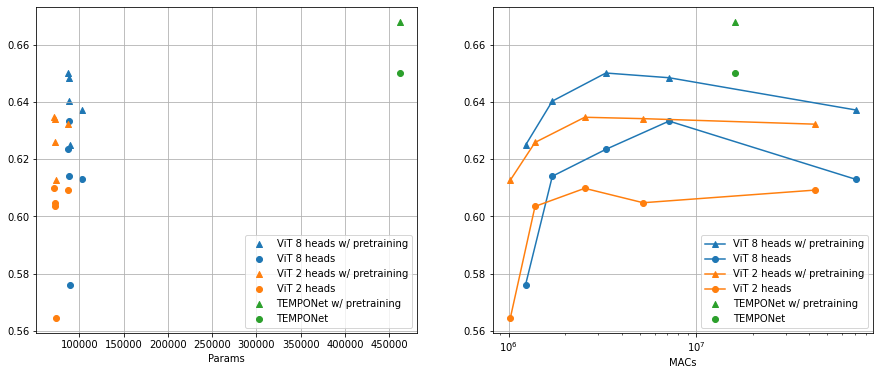

In [83]:
fig, ax = plt.subplots(figsize=(15, 6), ncols=2, sharey=True)
ax[1].yaxis.set_tick_params(labelleft=True)

res_.loc[res_['depth'] == 1, "label"] = "ViT 8 heads w/ pretraining"
res_.loc[res_['depth'] == 2, "label"] = "ViT 2 heads w/ pretraining"
res_untrained.loc[res_untrained['depth'] == 1, "label"] = "ViT 8 heads"
res_untrained.loc[res_untrained['depth'] == 2, "label"] = "ViT 2 heads"
for i, heads in enumerate([8, 2]):
    label = f"ViT {heads} heads w/ pretraining"
    sc = ax[0].scatter(res_[res_["label"] == label]["params"], res_[res_["label"] == label]["test accuracy steady avg2folds"], label=label, color=f"C{i}", marker='^')
    label = f"ViT {heads} heads"
    sc = ax[0].scatter(res_untrained[res_untrained["label"] == label]["params"], res_untrained[res_untrained["label"] == label]["test accuracy steady avg2folds"], label=label, color=f"C{i}", marker="o")

ax[0].scatter([tcn_params], [tcn_test_accuracy_steady_avg2folds], color='C2', label='TEMPONet w/ pretraining', marker='^')
ax[0].scatter([tcn_params], [tcn_test_accuracy_steady_avg2folds_nop], color='C2', label='TEMPONet', marker="o")
ax[0].legend()
#ax[0].set_title('Accuracy on test set with pretraining')
ax[0].set_xlabel("Params")
ax[0].grid("on")

for i, heads in enumerate([8, 2]):
    label = f"ViT {heads} heads w/ pretraining"
    sc = ax[1].plot(res_[res_["label"] == label]["MACs"], res_[res_["label"] == label]["test accuracy steady avg2folds"], label=label, color=f"C{i}", marker='^')
    label = f"ViT {heads} heads"
    sc = ax[1].plot(res_untrained[res_untrained["label"] == label]["MACs"], res_untrained[res_untrained["label"] == label]["test accuracy steady avg2folds"], label=label, color=f"C{i}", marker='o')

ax[1].scatter([tcn_macs], [tcn_test_accuracy_steady_avg2folds], color='C2', label='TEMPONet w/ pretraining', marker="^")
ax[1].scatter([tcn_macs], [tcn_test_accuracy_steady_avg2folds_nop], color='C2', label='TEMPONet', marker='o')
ax[1].legend()
ax[1].set_xlabel("MACs")
ax[1].set_xscale('log')
ax[1].grid("on")
#ax[1].set_title('Accuracy on test set with pretraining')

In [1]:
for i, depth in enumerate([1, 2]):
    r = res_[res_['depth'] == depth]
    plt.plot([str(x) for x in r['patch_size']], list(r['test accuracy steady avg2folds']), marker='^', label=f"ViT heads={8 if depth == 1 else 2}, depth={depth} w/ pretraining", color=f"C{i}", linestyle='-')
    r = res_untrained[res_untrained['depth'] == depth]
    plt.plot([str(x) for x in r['patch_size']], list(r['test accuracy steady avg2folds']), marker='o', label=f"ViT heads={8 if depth == 1 else 2}, depth={depth}", color=f"C{i}", linestyle='--')

plt.hlines(tcn_test_accuracy_steady_avg2folds, 0, 4, color='C2', label='TEMPONet w/ pretraining')
plt.hlines(tcn_test_accuracy_steady_avg2folds_nop, 0, 4, linestyle='--', color='C2', label='TEMPONet')

plt.grid('on')
plt.xlabel('patch size')
#plt.suptitle('ViT 2 head')
plt.title('5 session steady accuracy')
#plt.legend(title="depth", loc="upper right", bbox_to_anchor=(1.3, 1.02))
plt.legend(title="Model", loc="upper left", bbox_to_anchor=(1, 1.025))
plt.show()

NameError: name 'res_' is not defined

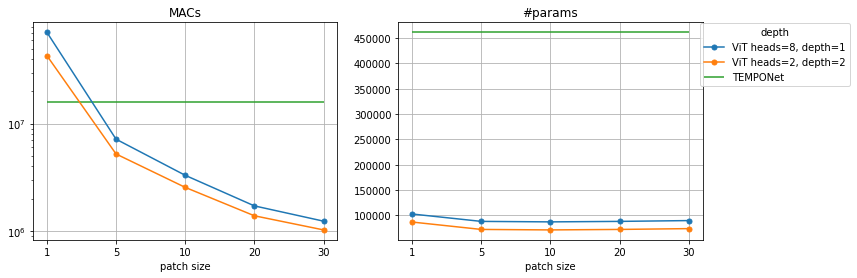

In [53]:
fig, ax = plt.subplots(figsize=(12,4), ncols=2)
for depth in [1, 2]:
    r = res_[res_['depth'] == depth]
    ax[0].plot([str(x) for x in r['patch_size']], list(r['MACs']), marker='.', markersize=10, label=f"ViT heads={8 if depth == 1 else 2}, depth={depth}")
    ax[1].plot([str(x) for x in r['patch_size']], list(r['params']), marker='.', markersize=10, label=f"ViT heads={8 if depth == 1 else 2}, depth={depth}")
    
ax[0].hlines(tcn_macs, 0, 4, color='C2', label='TEMPONet')
ax[1].hlines(tcn_params, 0, 4, color='C2', label='TEMPONet')
ax[0].set_yscale('log')
[a.grid('on') for a in ax]
[a.set_xlabel('patch size') for a in ax]
ax[0].set_title('MACs')
ax[1].set_title('#params')
#plt.legend(title="depth", loc="upper right", bbox_to_anchor=(1.35, 1.02))
plt.legend(title="depth", loc="upper right", bbox_to_anchor=(1.5, 1.02))

In [44]:
res_untrained

,window_size,patch_size,dim_projection,dim_ff,dim_head,n_heads,depth,dropout,emb_dropout,MACs,params,params_aff_ratio,pretraining,train accuracy steady fold1,train accuracy steady fold2,train accuracy steady avg2folds,validation accuracy steady fold1,validation accuracy steady fold2,test accuracy fold1,test accuracy fold2,test accuracy avg2folds,test accuracy steady fold1,test accuracy steady fold2,test accuracy steady avg2folds,test accuracy steady avg2folds std across sessions,test accuracy steady avg2folds std across subjects,test accuracy steady session6 avg2folds,test accuracy steady session7 avg2folds,test accuracy steady session8 avg2folds,test accuracy steady session9 avg2folds,test accuracy steady session10 avg2folds,test accuracy steady subj0 avg2folds,test accuracy steady subj1 avg2folds,test accuracy steady subj2 avg2folds,test accuracy steady subj3 avg2folds,test accuracy steady subj4 avg2folds,test accuracy steady subj5 avg2folds,test accuracy steady subj6 avg2folds,test accuracy steady subj7 avg2folds,test accuracy steady subj8 avg2folds,test accuracy steady subj9 avg2folds,test preds steady subj0 avg2folds,test preds steady subj1 avg2folds,test preds steady subj2 avg2folds,test preds steady subj3 avg2folds,test preds steady subj4 avg2folds,test preds steady subj5 avg2folds,test preds steady subj6 avg2folds,test preds steady subj7 avg2folds,test preds steady subj8 avg2folds,test preds steady subj9 avg2folds
5,300,1,64,128,32,8,1,0.2,0,71314944,102664,0.798287,False,0.985789,0.983329,0.984559,0.701433,0.699674,0.466595,0.457042,0.461818,0.619212,0.606539,0.612876,0.016798,0.091373,0.625620,0.611721,0.637124,0.597862,0.592050,0.732525,0.662260,0.604818,0.645532,0.783675,0.615406,0.539481,0.525583,0.476999,0.542475,"[43623, 7985, 6930, 9301, 5161, 8475, 9596, 6181]","[36690, 6943, 7554, 8622, 10251, 13566, 7383, ...","[57632, 4787, 5930, 5885, 7374, 7356, 5806, 2632]","[48957, 7539, 4213, 6970, 5851, 10655, 6606, 6...","[52615, 9619, 6726, 6708, 2883, 6705, 8355, 3719]","[49027, 5022, 5577, 5356, 6522, 12257, 10181, ...","[39280, 6921, 8431, 3582, 11105, 7018, 14210, ...","[62704, 10288, 6732, 4327, 3253, 1404, 4167, 5...","[66829, 11211, 3221, 3415, 4268, 3634, 4247, 2...","[45716, 4416, 8447, 8428, 10921, 10293, 4035, ..."
5,300,1,64,128,32,8,1,0.2,0,71314944,102664,0.798287,False,0.985789,0.983329,0.984559,0.701433,0.699674,0.466595,0.457042,0.461818,0.619212,0.606539,0.612876,0.016798,0.091373,0.625620,0.611721,0.637124,0.597862,0.592050,0.732525,0.662260,0.604818,0.645532,0.783675,0.615406,0.539481,0.525583,0.476999,0.542475,"[43623, 7985, 6930, 9301, 5161, 8475, 9596, 6181]","[36690, 6943, 7554, 8622, 10251, 13566, 7383, ...","[57632, 4787, 5930, 5885, 7374, 7356, 5806, 2632]","[48957, 7539, 4213, 6970, 5851, 10655, 6606, 6...","[52615, 9619, 6726, 6708, 2883, 6705, 8355, 3719]","[49027, 5022, 5577, 5356, 6522, 12257, 10181, ...","[39280, 6921, 8431, 3582, 11105, 7018, 14210, ...","[62704, 10288, 6732, 4327, 3253, 1404, 4167, 5...","[66829, 11211, 3221, 3415, 4268, 3634, 4247, 2...","[45716, 4416, 8447, 8428, 10921, 10293, 4035, ..."
6,300,5,64,128,32,8,1,0.2,0,7171584,88072,0.798287,False,0.978788,0.972806,0.975797,0.707787,0.707986,0.484315,0.473693,0.479004,0.640167,0.626368,0.633268,0.016873,0.090115,0.639899,0.622290,0.661144,0.631630,0.611376,0.760392,0.692517,0.614760,0.661398,0.791803,0.635853,0.571118,0.535996,0.499801,0.569041,"[41244, 9413, 8238, 8920, 4555, 10378, 9306, 5...","[36581, 8157, 4991, 9038, 14573, 11720, 6317, ...","[53427, 6255, 9181, 4568, 6746, 9324, 4980, 2921]","[46214, 7386, 4599, 7574, 6777, 11739, 6804, 5...","[52171, 7312, 9313, 8310, 4397, 6062, 5583, 4182]","[48261, 5135, 6214, 4521, 7790, 11098, 8875, 4...","[38733, 7493, 8492, 4659, 12838, 8852, 10695, ...","[62939, 15330, 4351, 4371, 2686, 1033, 3802, 3...","[68210, 6082, 4445, 3763, 4702, 4646, 4820, 2400]","[43033, 3957, 9282, 9687, 8095, 11458, 5386, 6..."
6,300,5,64,128,32,8,1,0.2,0,7171584,88072,0.798287,False,0.9787

In [113]:
tcn_macs / (1e6)

16.028672

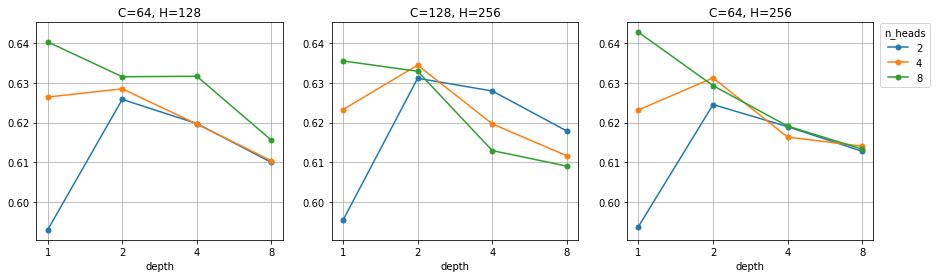

In [53]:
res = get_rows(all_res_vit, 
               {'patch_size': 20, 'dim_head': 32,
                'pretraining': 'fold1', 'pretraining_dropout': .2, 'pretraining_epochs': 100, 'finetune_epochs': 20})

fig, ax = plt.subplots(figsize=(15, 4), ncols=3, sharey=True)
ax[1].yaxis.set_tick_params(labelleft=True)
ax[2].yaxis.set_tick_params(labelleft=True)

plot_r(res[(res["dim_projection"] == 64) & (res["dim_ff"] == 128)], ax[0], legend=False)
plot_r(res[(res["dim_projection"] == 128)], ax[1], legend=False)
plot_r(res[(res["dim_projection"] == 64) & (res["dim_ff"] == 256)], ax[2], legend=True)

ax[0].set_title("C=64, H=128")
ax[1].set_title("C=128, H=256")
ax[2].set_title("C=64, H=256")

None

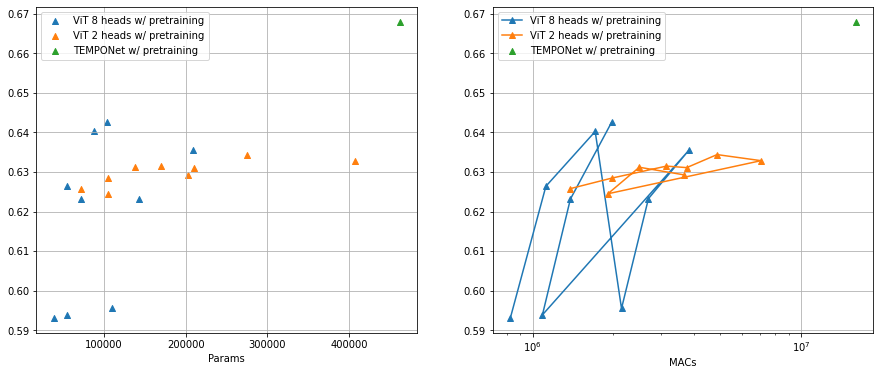

In [51]:
res_ = res
tcn = all_res_tcn.loc[all_res_tcn[all_res_tcn['pretraining'] == 'fold1'].index[0]]
tcn_macs, tcn_params, tcn_test_accuracy_steady_avg2folds = tcn['MACs'], tcn['params'], tcn['test accuracy steady avg2folds']


fig, ax = plt.subplots(figsize=(15, 6), ncols=2, sharey=True)
ax[1].yaxis.set_tick_params(labelleft=True)

res_.loc[res_['depth'] == 1, "label"] = "ViT 8 heads w/ pretraining"
res_.loc[res_['depth'] == 2, "label"] = "ViT 2 heads w/ pretraining"
#res_untrained.loc[res_untrained['depth'] == 1, "label"] = "ViT 8 heads"
#res_untrained.loc[res_untrained['depth'] == 2, "label"] = "ViT 2 heads"
for i, heads in enumerate([8, 2]):
    label = f"ViT {heads} heads w/ pretraining"
    sc = ax[0].scatter(res_[res_["label"] == label]["params"], res_[res_["label"] == label]["test accuracy steady avg2folds"], label=label, color=f"C{i}", marker='^')
    label = f"ViT {heads} heads"
    #sc = ax[0].scatter(res_untrained[res_untrained["label"] == label]["params"], res_untrained[res_untrained["label"] == label]["test accuracy steady avg2folds"], label=label, color=f"C{i}", marker="o")

ax[0].scatter([tcn_params], [tcn_test_accuracy_steady_avg2folds], color='C2', label='TEMPONet w/ pretraining', marker='^')
#ax[0].scatter([tcn_params], [tcn_test_accuracy_steady_avg2folds_nop], color='C2', label='TEMPONet', marker="o")
ax[0].legend()
#ax[0].set_title('Accuracy on test set with pretraining')
ax[0].set_xlabel("Params")
ax[0].grid("on")

for i, heads in enumerate([8, 2]):
    label = f"ViT {heads} heads w/ pretraining"
    sc = ax[1].plot(res_[res_["label"] == label]["MACs"], res_[res_["label"] == label]["test accuracy steady avg2folds"], label=label, color=f"C{i}", marker='^')
    label = f"ViT {heads} heads"
    #sc = ax[1].plot(res_untrained[res_untrained["label"] == label]["MACs"], res_untrained[res_untrained["label"] == label]["test accuracy steady avg2folds"], label=label, color=f"C{i}", marker='o')

ax[1].scatter([tcn_macs], [tcn_test_accuracy_steady_avg2folds], color='C2', label='TEMPONet w/ pretraining', marker="^")
#ax[1].scatter([tcn_macs], [tcn_test_accuracy_steady_avg2folds_nop], color='C2', label='TEMPONet', marker='o')
ax[1].legend()
ax[1].set_xlabel("MACs")
ax[1].set_xscale('log')
ax[1].grid("on")
#ax[1].set_title('Accuracy on test set with pretraining')

In [ ]:
res = get_rows(all_res_vit, {'patch_size': 20, 'dim_head': 32, 'dim_projection': 128, 'pretraining': 'fold1',})

fig, ax = plt.subplots(figsize=(15, 4), ncols=4, sharey=True)
ax[1].yaxis.set_tick_params(labelleft=True)
ax[2].yaxis.set_tick_params(labelleft=True)
ax[3].yaxis.set_tick_params(labelleft=True)

plot_r(res[(res["pretraining_dropout"] == .2) & (res["pretraining_epochs"] == 100)], ax[0], legend=False)
plot_r(res[(res["pretraining_dropout"] == .4) & (res["pretraining_epochs"] == 100)], ax[1], legend=False)
plot_r(res[(res["pretraining_dropout"] == .4) & (res["pretraining_epochs"] == 200)], ax[2], legend=False)
plot_r(res[(res["pretraining_dropout"] == .4) & (res["pretraining_epochs"] == 300)], ax[3], legend=True)

ax[0].set_title("Dropout = 0.2")
ax[1].set_title("Dropout = 0.4 per 100 epoche")
ax[2].set_title("Dropout = 0.4 per 200 epoche")
ax[3].set_title("Dropout = 0.4 per 300 epoche")

None

In [ ]:
res = get_rows(all_res_vit, {'patch_size': 20, 'dim_head': 32, 'dim_projection': 64, 'dim_ff': 256, 'pretraining': 'fold1',})

fig, ax = plt.subplots(figsize=(10, 4), ncols=2, sharey=True)
ax[1].yaxis.set_tick_params(labelleft=True)

plot_r(res[(res["pretraining_dropout"] == .2) & (res["pretraining_epochs"] == 100)], ax[0], legend=False)
plot_r(res[(res["pretraining_dropout"] == .5) & (res["pretraining_epochs"] == 100)], ax[1], legend=True)

ax[0].set_title("Dropout = 0.2 per 100 epoche")
ax[1].set_title("Dropout = 0.5 per 100 epoche")

None